In [76]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

from dataclasses import dataclass
from data_preprocessing.dataset_dataloader import create_data_loader
from transformers import AutoTokenizer
from tqdm import tqdm

# --- Local Application/Module Imports ---
import data_loader.data_loader
import data_preprocessing.data_preprocessing
import data_preprocessing.llm_augmentation
import models.models
import visualizations.visualizations
import utils.utils

importlib.reload(data_loader.data_loader)
from data_loader.data_loader import *

importlib.reload(data_preprocessing.data_preprocessing)

importlib.reload(data_preprocessing.llm_augmentation)
from data_preprocessing.llm_augmentation import *

importlib.reload(models.models)
from models.models import *

importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

importlib.reload(utils.utils)
from utils.utils import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading data and splitting into train, validation, and test sets

In [2]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


In [3]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


----

In [4]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    dropout: float
    attention_dropout: float
    device: str
    num_classes: int
    max_len: int

config = Config(
    batch_size = 16,
    model="FacebookAI/roberta-large",
    seed=RANDOM_SEED,
    lr=3e-5,
    dropout=0.1,
    attention_dropout=0.1,
    device=device,
    num_classes=3,
    max_len=64,
)

def load_model(config: Config, model_name, model_path, test_df):
    config.model = model_name

    llm_tokenizer = AutoTokenizer.from_pretrained(config.model)
    llm_model = load_blank_model(config)

    # Load saved model state dict
    state_dict = torch.load(model_path, map_location=device)
    llm_model.load_state_dict(state_dict)

    llm_model.to(device)
    llm_model.eval()


    loss_fn = nn.CrossEntropyLoss().to(device)
    test_data_loader = create_data_loader(test_df, llm_tokenizer, config.max_len, config.batch_size)

    return llm_model, loss_fn, test_data_loader

### distilbert-base-cased

In [5]:
model_name = "distilbert/distilbert-base-cased"
model_path = "../fine_tuned_models/distilbert-base-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
y_review_texts, y_pred_dbc, y_pred_probs_dbc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [7]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dbc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dbc))

              precision    recall  f1-score   support

    negative       0.68      0.64      0.66      2191
     neutral       0.77      0.80      0.79      4915
    positive       0.73      0.73      0.73      3104

    accuracy                           0.74     10210
   macro avg       0.73      0.72      0.73     10210
weighted avg       0.74      0.74      0.74     10210

L-score is:  0.847796278158668


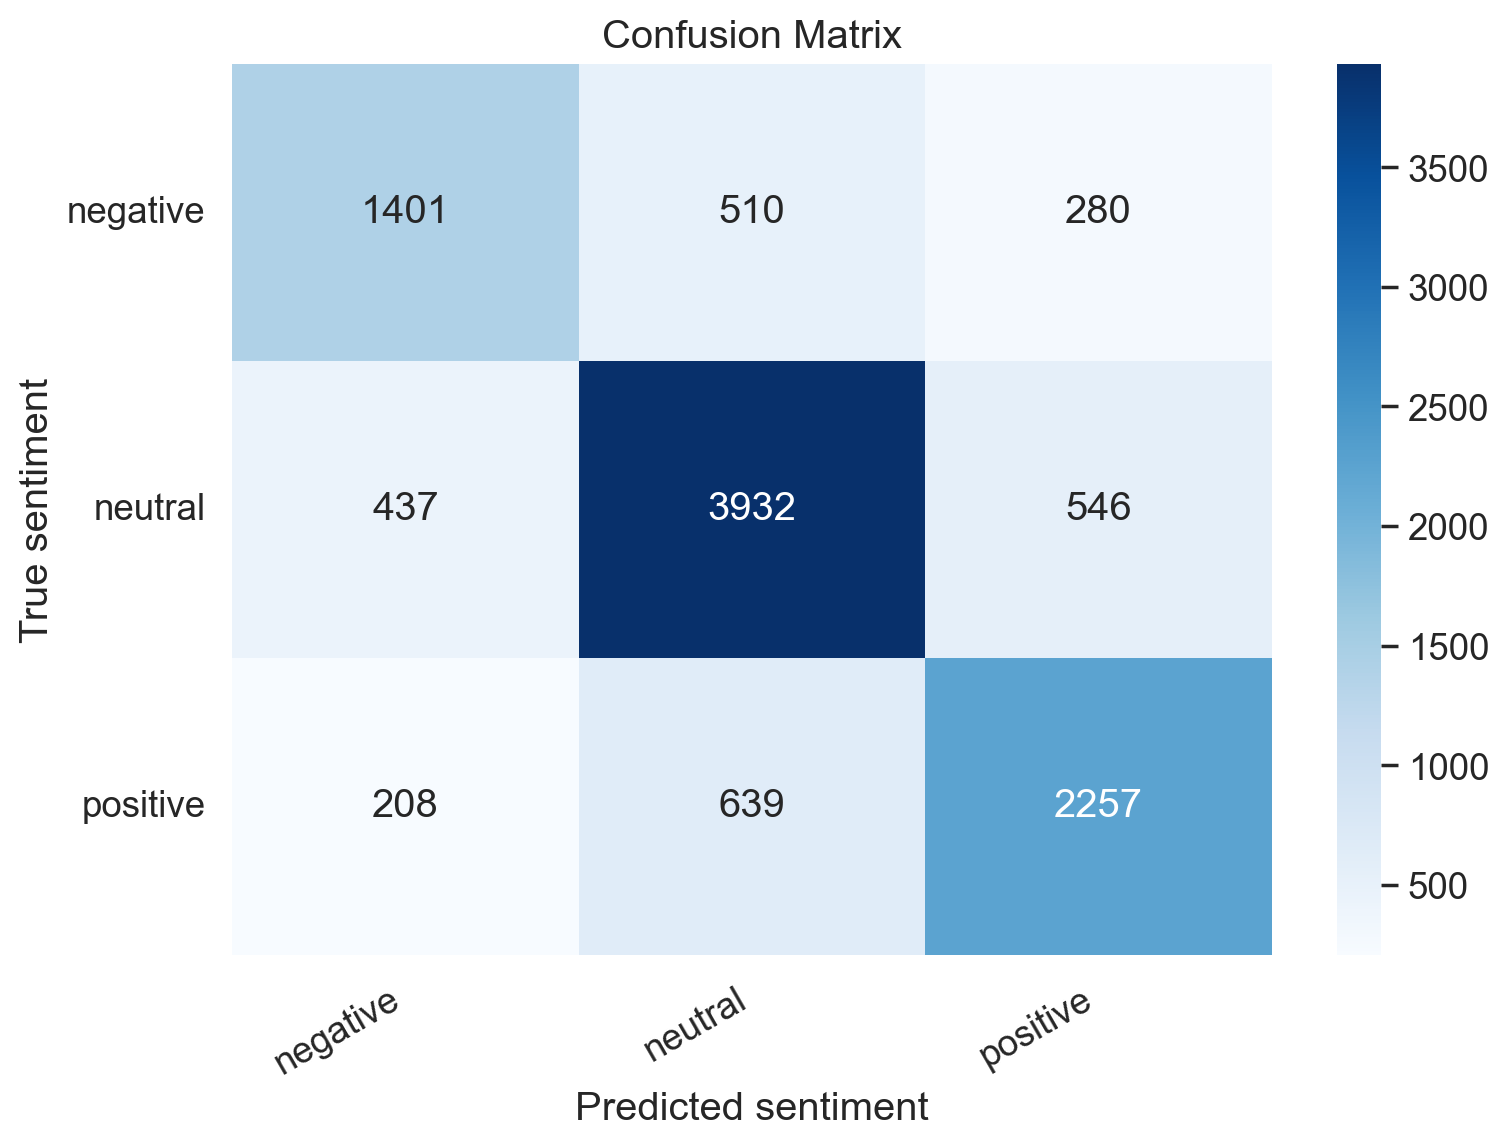

In [8]:
plot_confusion_matrix(y_test, y_pred_dbc, class_names)

In [9]:
classification_breakdown(y_test, y_pred_dbc)

Total samples: 10210
Correctly classified: 7590
Partially misclassified (neutral <-> pos/neg): 2132
Misclassified (positive <-> negative): 488


{'correct': 7590, 'partially_misclassified': 2132, 'fully_misclassified': 488}

### distilbert-base-multilingual-cased

In [10]:
model_name = "distilbert/distilbert-base-multilingual-cased"
model_path = "../fine_tuned_models/distilbert-base-multilingual-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
y_review_texts, y_pred_dbmc, y_pred_probs_dbmc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [12]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dbmc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dbmc))

              precision    recall  f1-score   support

    negative       0.65      0.58      0.61      2191
     neutral       0.74      0.83      0.78      4915
    positive       0.74      0.65      0.69      3104

    accuracy                           0.72     10210
   macro avg       0.71      0.69      0.70     10210
weighted avg       0.72      0.72      0.72     10210

L-score is:  0.8334476003917728


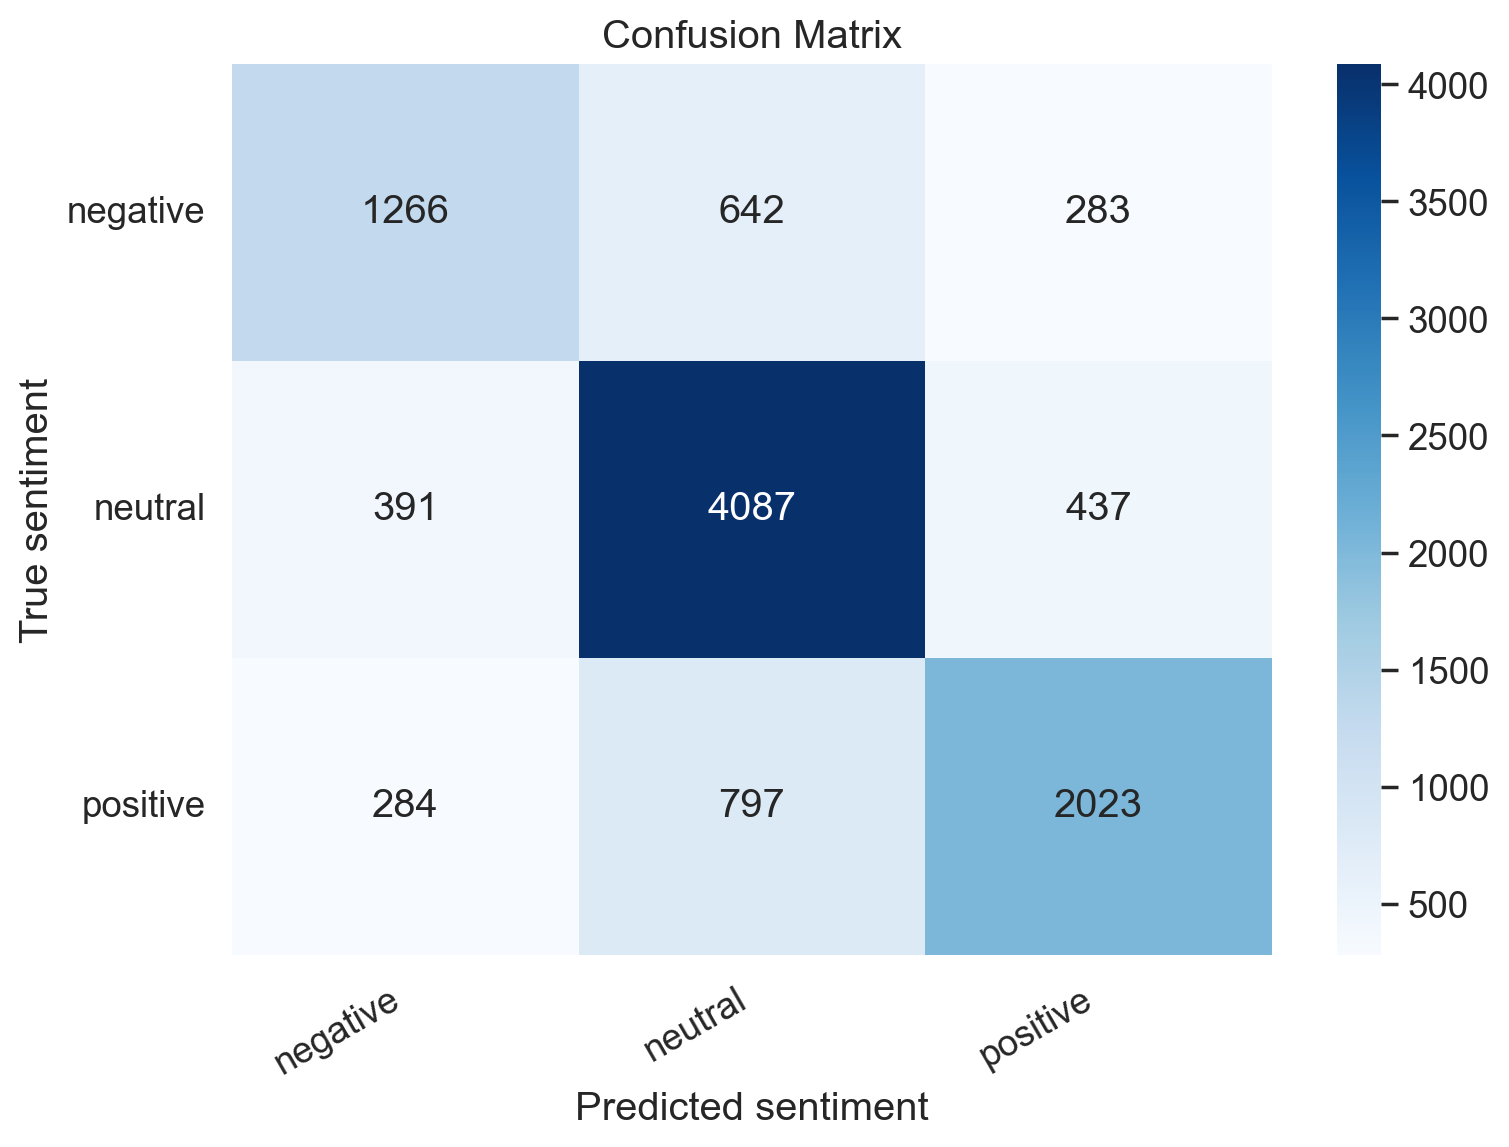

In [13]:
plot_confusion_matrix(y_test, y_pred_dbmc, class_names)

In [14]:
classification_breakdown(y_test, y_pred_dbmc)

Total samples: 10210
Correctly classified: 7376
Partially misclassified (neutral <-> pos/neg): 2267
Misclassified (positive <-> negative): 567


{'correct': 7376, 'partially_misclassified': 2267, 'fully_misclassified': 567}

### google-bert/bert-base-cased

In [69]:
model_name = "google-bert/bert-base-cased"
model_path = "../fine_tuned_models/bert-base-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
y_review_texts, y_pred_bbc, y_pred_probs_bbc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [71]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_bbc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_bbc))

              precision    recall  f1-score   support

    negative       0.70      0.68      0.69      2191
     neutral       0.79      0.80      0.80      4915
    positive       0.75      0.75      0.75      3104

    accuracy                           0.76     10210
   macro avg       0.75      0.74      0.74     10210
weighted avg       0.76      0.76      0.76     10210

L-score is:  0.8582761998041136


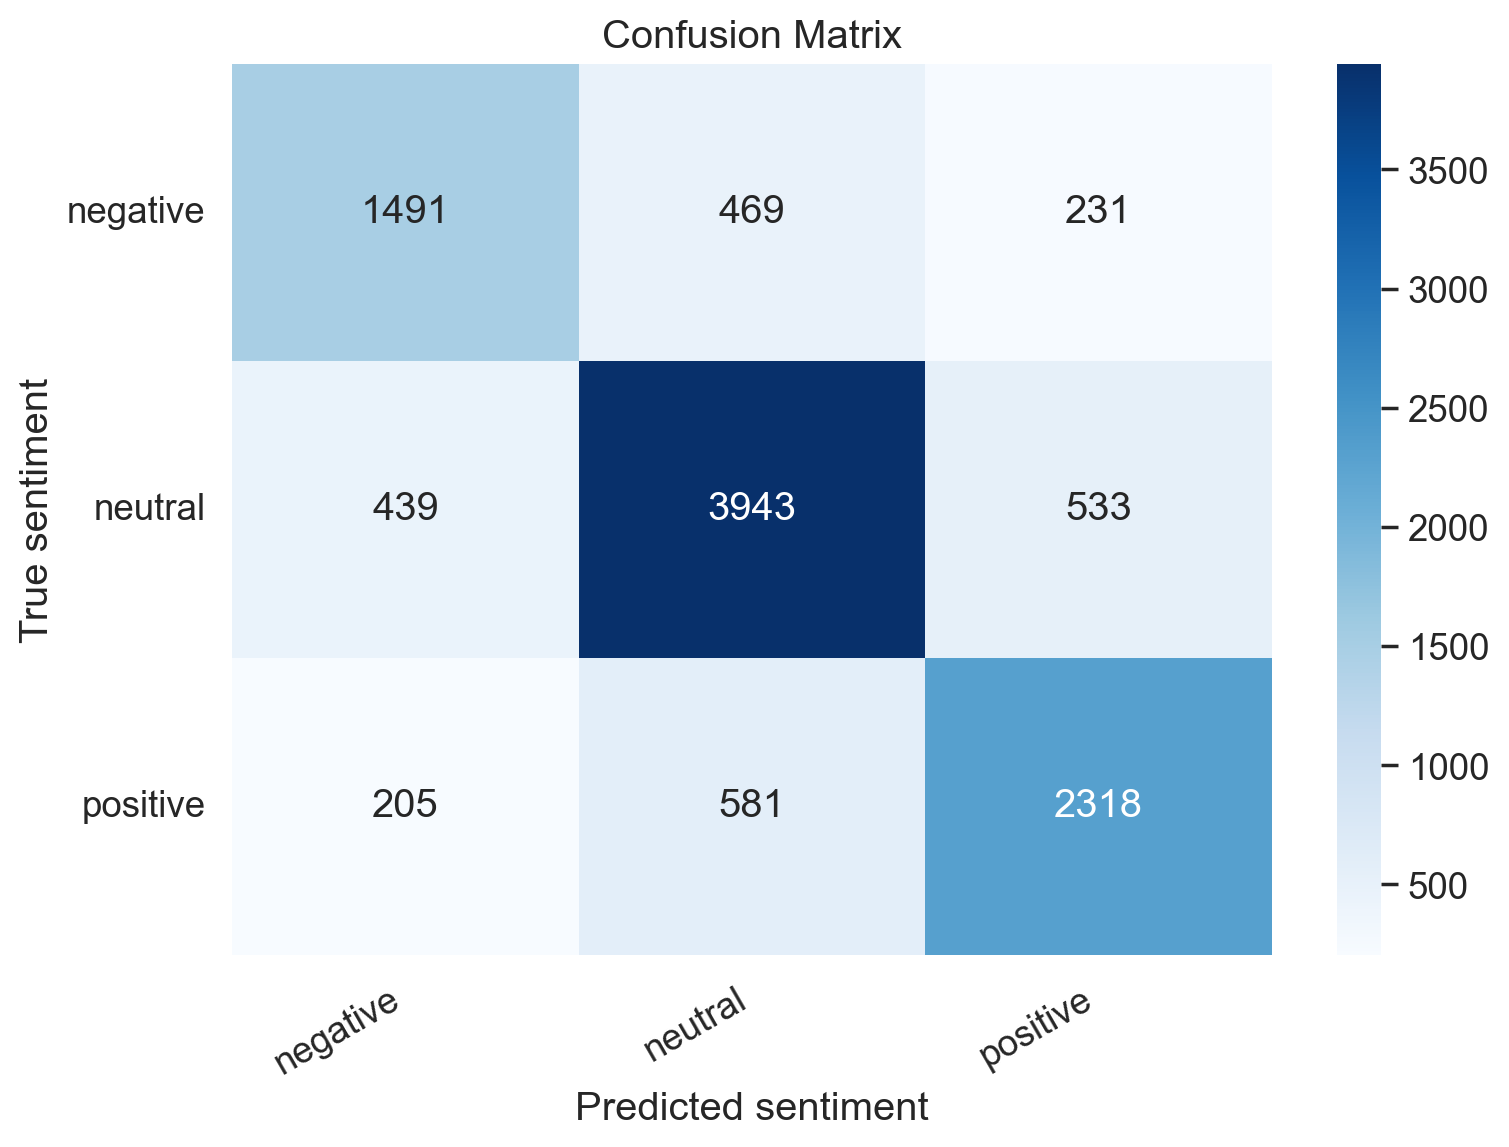

In [72]:
plot_confusion_matrix(y_test, y_pred_bbc, class_names)

In [73]:
classification_breakdown(y_test, y_pred_bbc)

Total samples: 10210
Correctly classified: 7752
Partially misclassified (neutral <-> pos/neg): 2022
Misclassified (positive <-> negative): 436


{'correct': 7752, 'partially_misclassified': 2022, 'fully_misclassified': 436}

### google-bert/bert-base-multilingual-cased

In [77]:
model_name = "google-bert/bert-base-multilingual-cased"
model_path = "../fine_tuned_models/bert-base-multilingual-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
y_review_texts, y_pred_bbmc, y_pred_probs_bbmc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [79]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_bbmc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dbc))

              precision    recall  f1-score   support

    negative       0.64      0.61      0.63      2191
     neutral       0.77      0.79      0.78      4915
    positive       0.73      0.71      0.72      3104

    accuracy                           0.73     10210
   macro avg       0.71      0.71      0.71     10210
weighted avg       0.73      0.73      0.73     10210

L-score is:  0.847796278158668


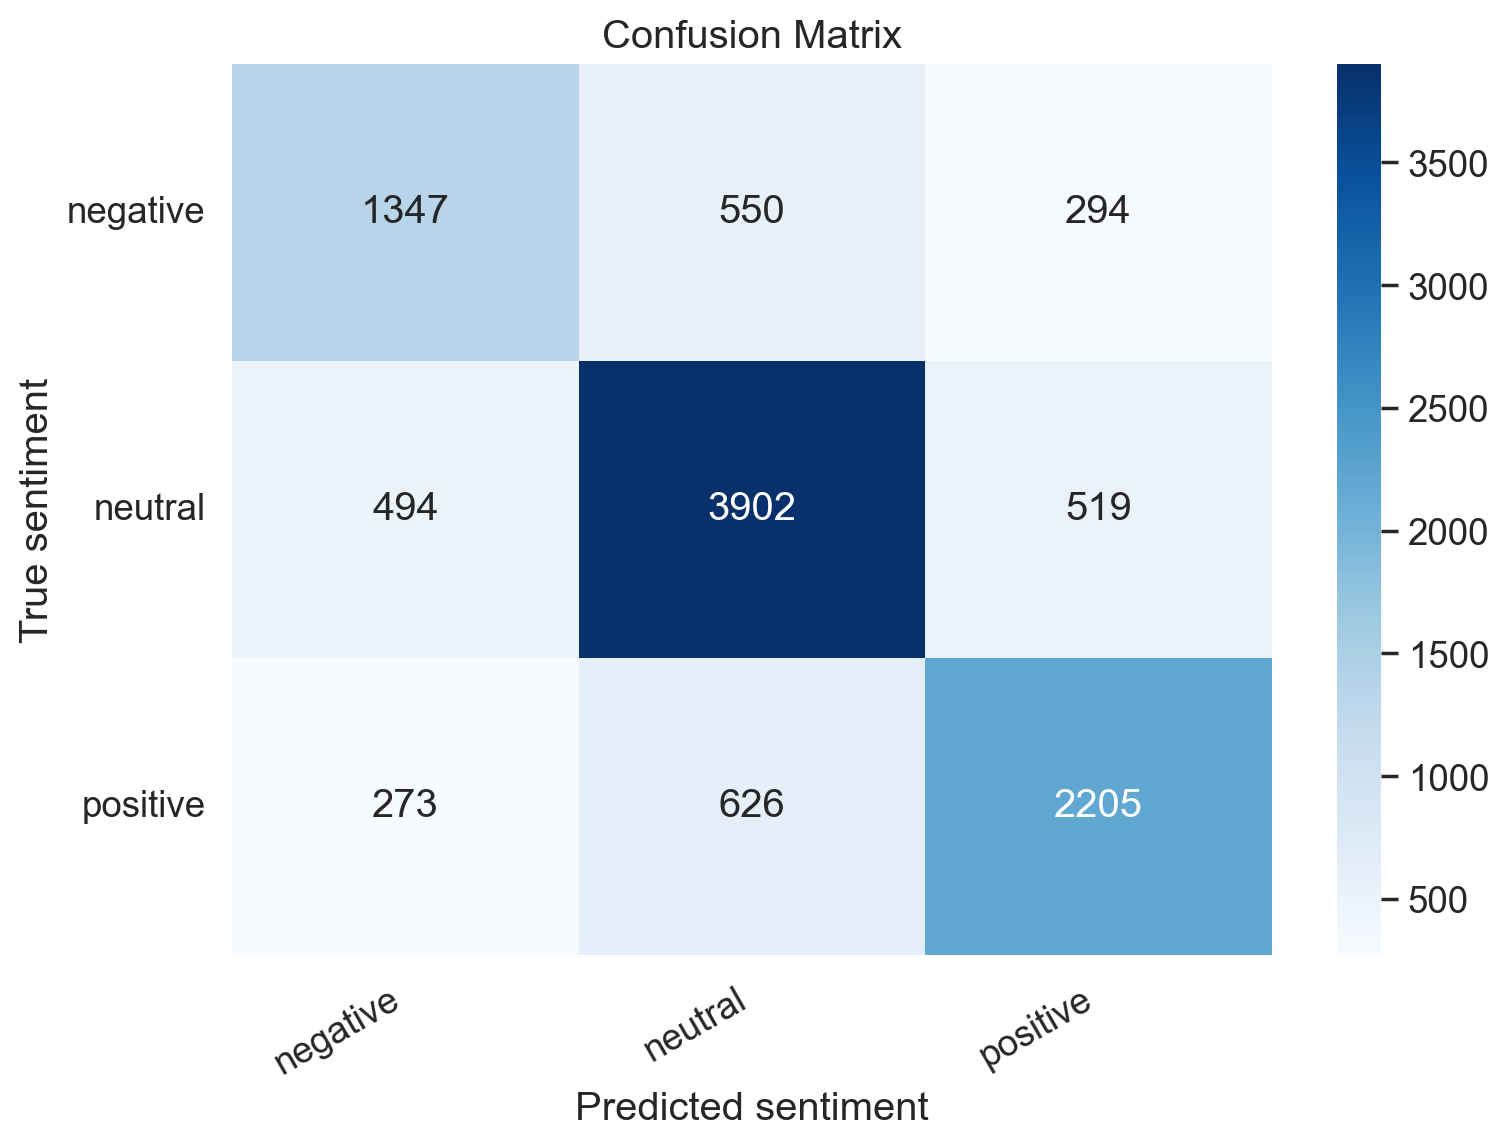

In [80]:
plot_confusion_matrix(y_test, y_pred_bbmc, class_names)

In [81]:
classification_breakdown(y_test, y_pred_bbmc)

Total samples: 10210
Correctly classified: 7454
Partially misclassified (neutral <-> pos/neg): 2189
Misclassified (positive <-> negative): 567


{'correctly_classified': 7454,
 'partially_misclassified': 2189,
 'fully_misclassified': 567}

### roberta-base

In [15]:
model_name = "FacebookAI/roberta-base"
model_path = "../fine_tuned_models/roberta-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
y_review_texts, y_pred_rb, y_pred_probs_rb, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [17]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_rb, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_rb))

              precision    recall  f1-score   support

    negative       0.76      0.74      0.75      2191
     neutral       0.82      0.82      0.82      4915
    positive       0.79      0.79      0.79      3104

    accuracy                           0.80     10210
   macro avg       0.79      0.79      0.79     10210
weighted avg       0.80      0.80      0.80     10210

L-score is:  0.8821743388834475


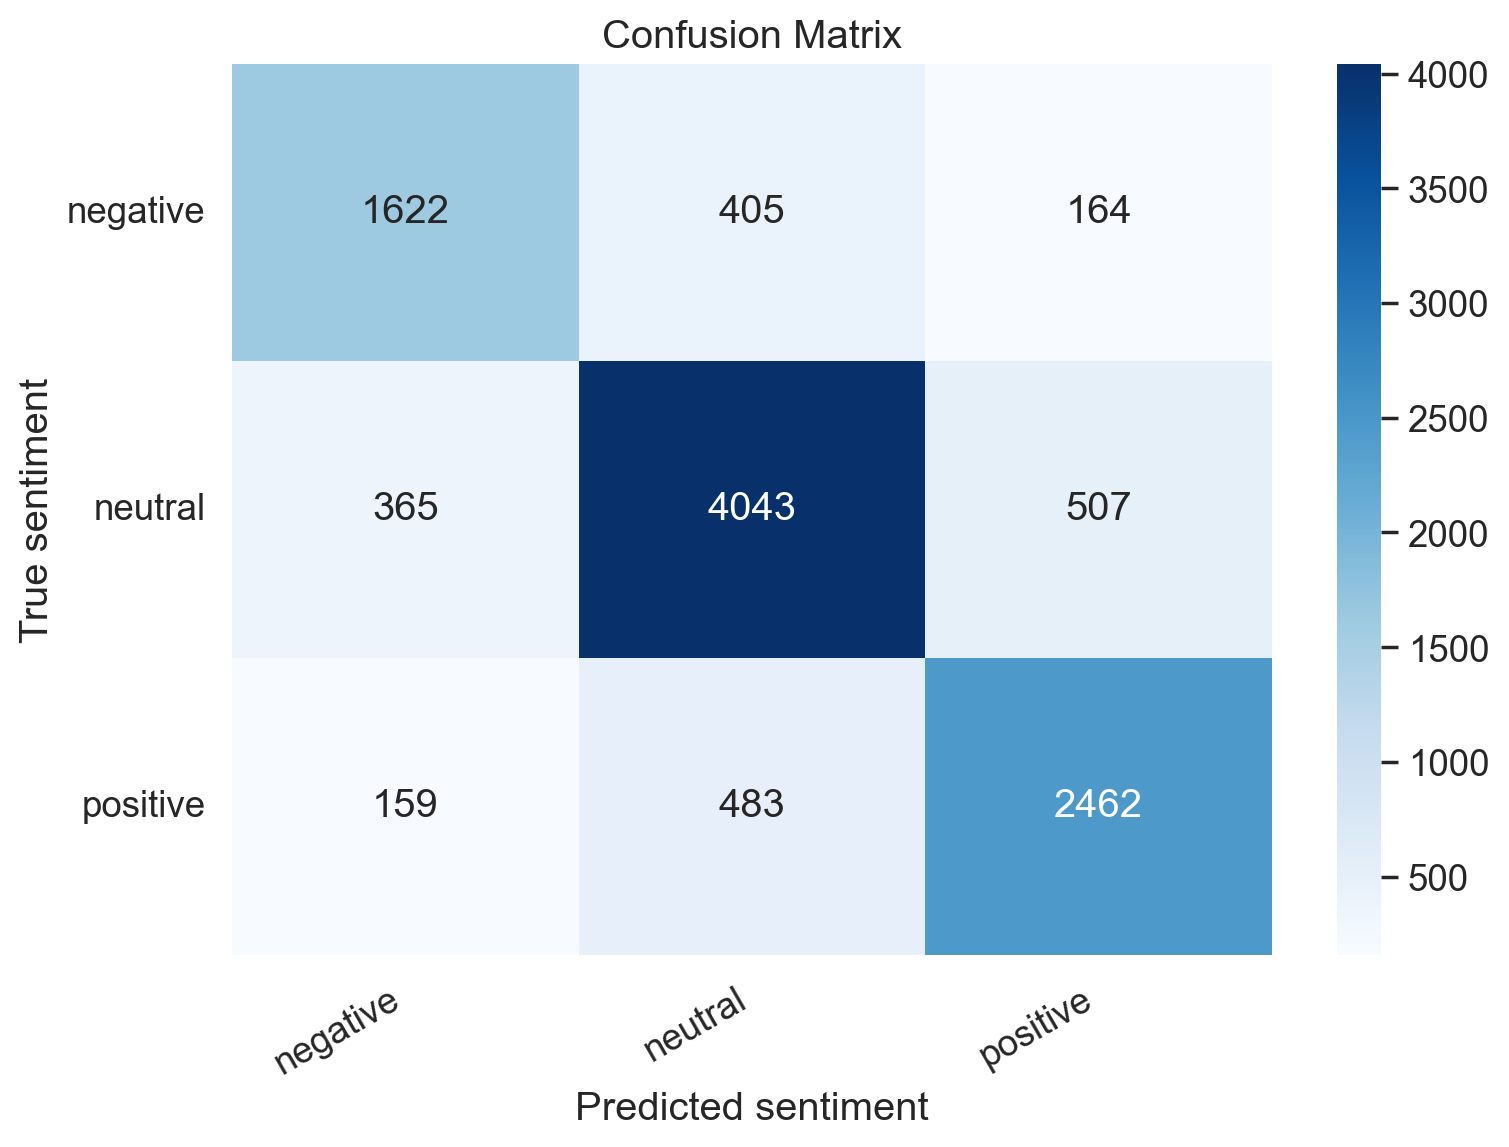

In [18]:
plot_confusion_matrix(y_test, y_pred_rb, class_names)

In [19]:
classification_breakdown(y_test, y_pred_rb)

Total samples: 10210
Correctly classified: 8127
Partially misclassified (neutral <-> pos/neg): 1760
Misclassified (positive <-> negative): 323


{'correct': 8127, 'partially_misclassified': 1760, 'fully_misclassified': 323}

### xlm-roberta-base

In [20]:
model_name = "FacebookAI/xlm-roberta-base"
model_path = "../fine_tuned_models/xlm-roberta-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
y_review_texts, y_pred_xlmrb, y_pred_probs_xlmrb, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [22]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_xlmrb, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_xlmrb))

              precision    recall  f1-score   support

    negative       0.71      0.68      0.69      2191
     neutral       0.81      0.81      0.81      4915
    positive       0.75      0.77      0.76      3104

    accuracy                           0.77     10210
   macro avg       0.75      0.75      0.75     10210
weighted avg       0.77      0.77      0.77     10210

L-score is:  0.8612634671890304


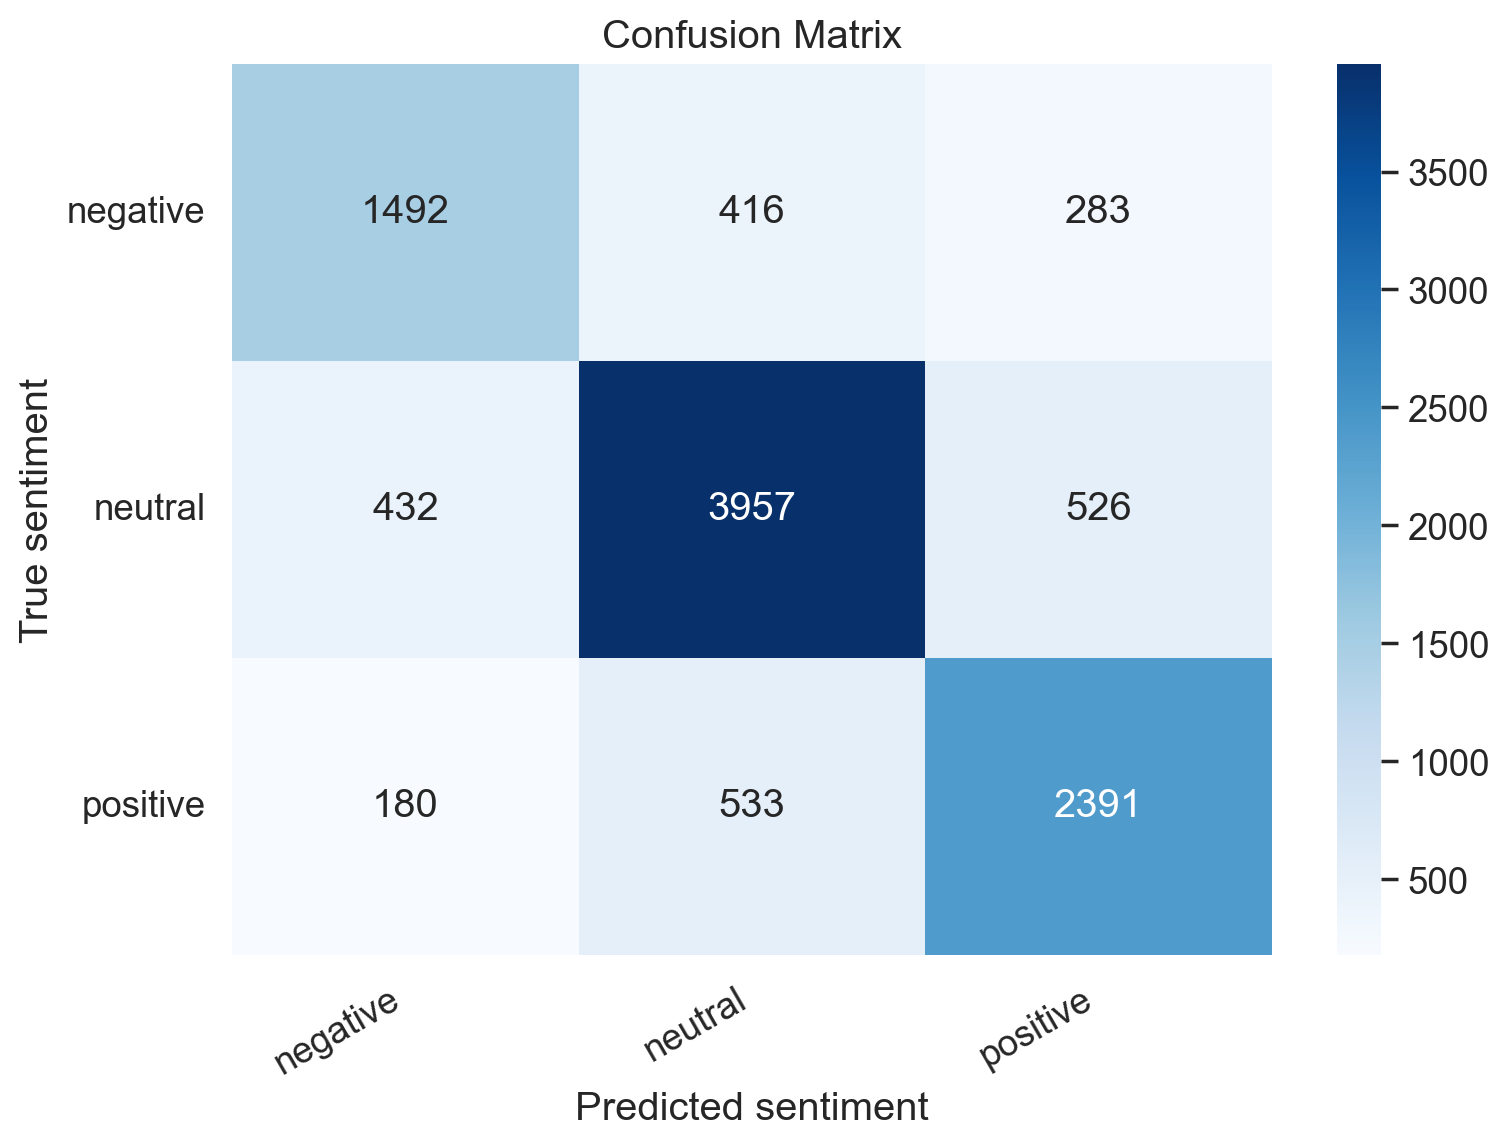

In [23]:
plot_confusion_matrix(y_test, y_pred_xlmrb, class_names)

In [24]:
classification_breakdown(y_test, y_pred_xlmrb)

Total samples: 10210
Correctly classified: 7840
Partially misclassified (neutral <-> pos/neg): 1907
Misclassified (positive <-> negative): 463


{'correct': 7840, 'partially_misclassified': 1907, 'fully_misclassified': 463}

### roberta-large

In [25]:
model_name = "FacebookAI/roberta-large"
model_path = "../fine_tuned_models/roberta-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
y_review_texts, y_pred_rl, y_pred_probs_rl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [27]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_rl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_rl))

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.79      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.79      0.80     10210
weighted avg       0.81      0.81      0.81     10210

L-score is:  0.88692458374143


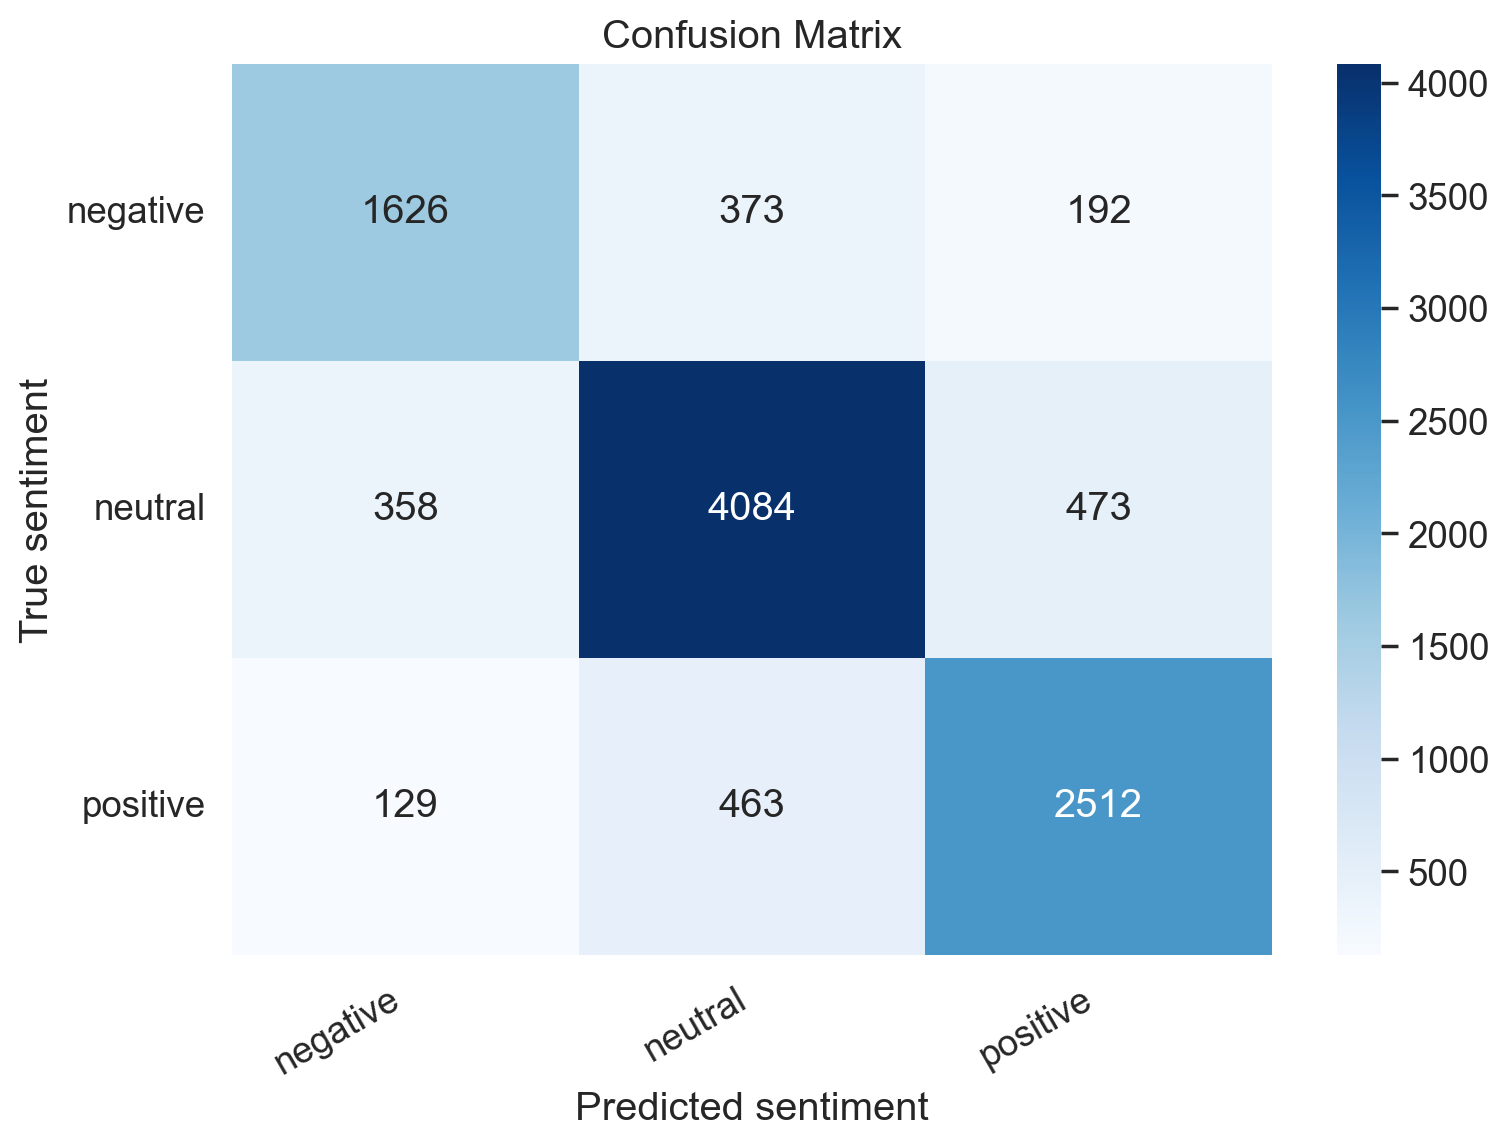

In [28]:
plot_confusion_matrix(y_test, y_pred_rl, class_names)

In [29]:
classification_breakdown(y_test, y_pred_rl)

Total samples: 10210
Correctly classified: 8222
Partially misclassified (neutral <-> pos/neg): 1667
Misclassified (positive <-> negative): 321


{'correct': 8222, 'partially_misclassified': 1667, 'fully_misclassified': 321}

### xlm-roberta-large

In [30]:
model_name = "FacebookAI/xlm-roberta-large"
model_path = "../fine_tuned_models/xlm-roberta-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
y_review_texts, y_pred_xmlrl, y_pred_probs_xmlrl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [32]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_xmlrl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_xmlrl))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2191
     neutral       0.48      1.00      0.65      4915
    positive       0.00      0.00      0.00      3104

    accuracy                           0.48     10210
   macro avg       0.16      0.33      0.22     10210
weighted avg       0.23      0.48      0.31     10210

L-score is:  0.7406953966699314


/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


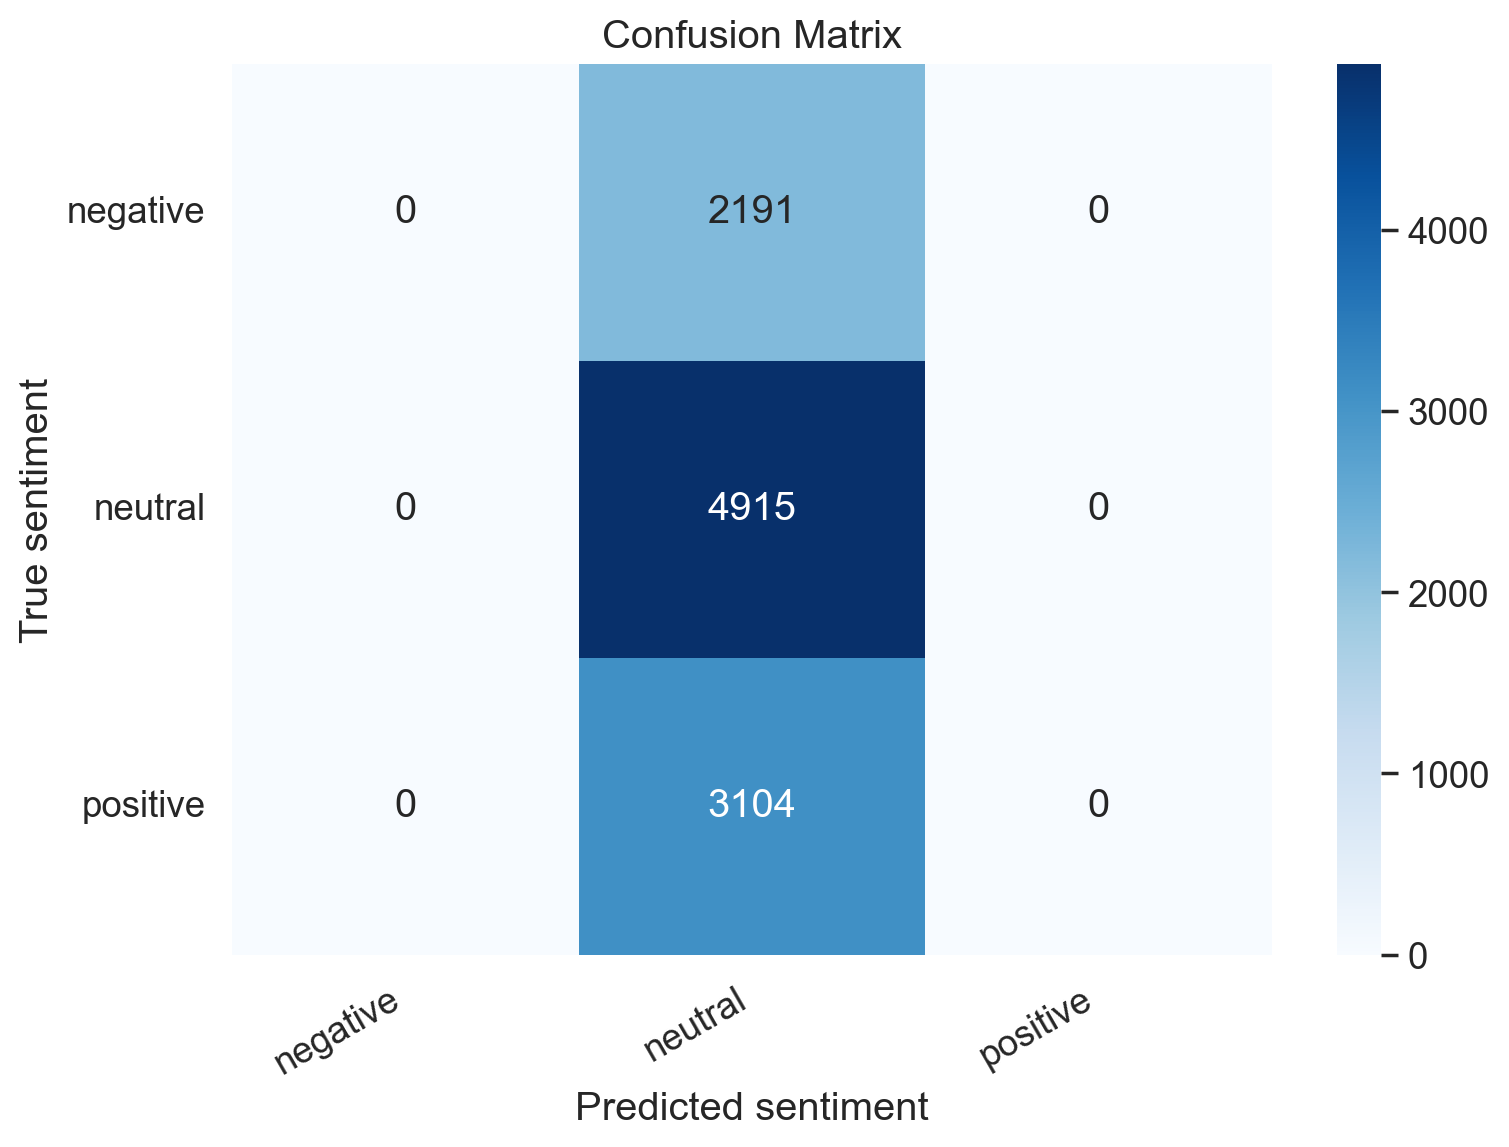

In [33]:
plot_confusion_matrix(y_test, y_pred_xmlrl, class_names)

In [34]:
classification_breakdown(y_test, y_pred_xmlrl)

Total samples: 10210
Correctly classified: 4915
Partially misclassified (neutral <-> pos/neg): 5295
Misclassified (positive <-> negative): 0


{'correct': 4915, 'partially_misclassified': 5295, 'fully_misclassified': 0}

### deberta-v3-base

In [35]:
model_name = "microsoft/deberta-v3-base"
model_path = "../fine_tuned_models/deberta-v3-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
y_review_texts, y_pred_db, y_pred_probs_db, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [37]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_db, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_db))

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.80      0.81      0.81      3104

    accuracy                           0.81     10210
   macro avg       0.81      0.81      0.81     10210
weighted avg       0.81      0.81      0.81     10210

L-score is:  0.8938295788442703


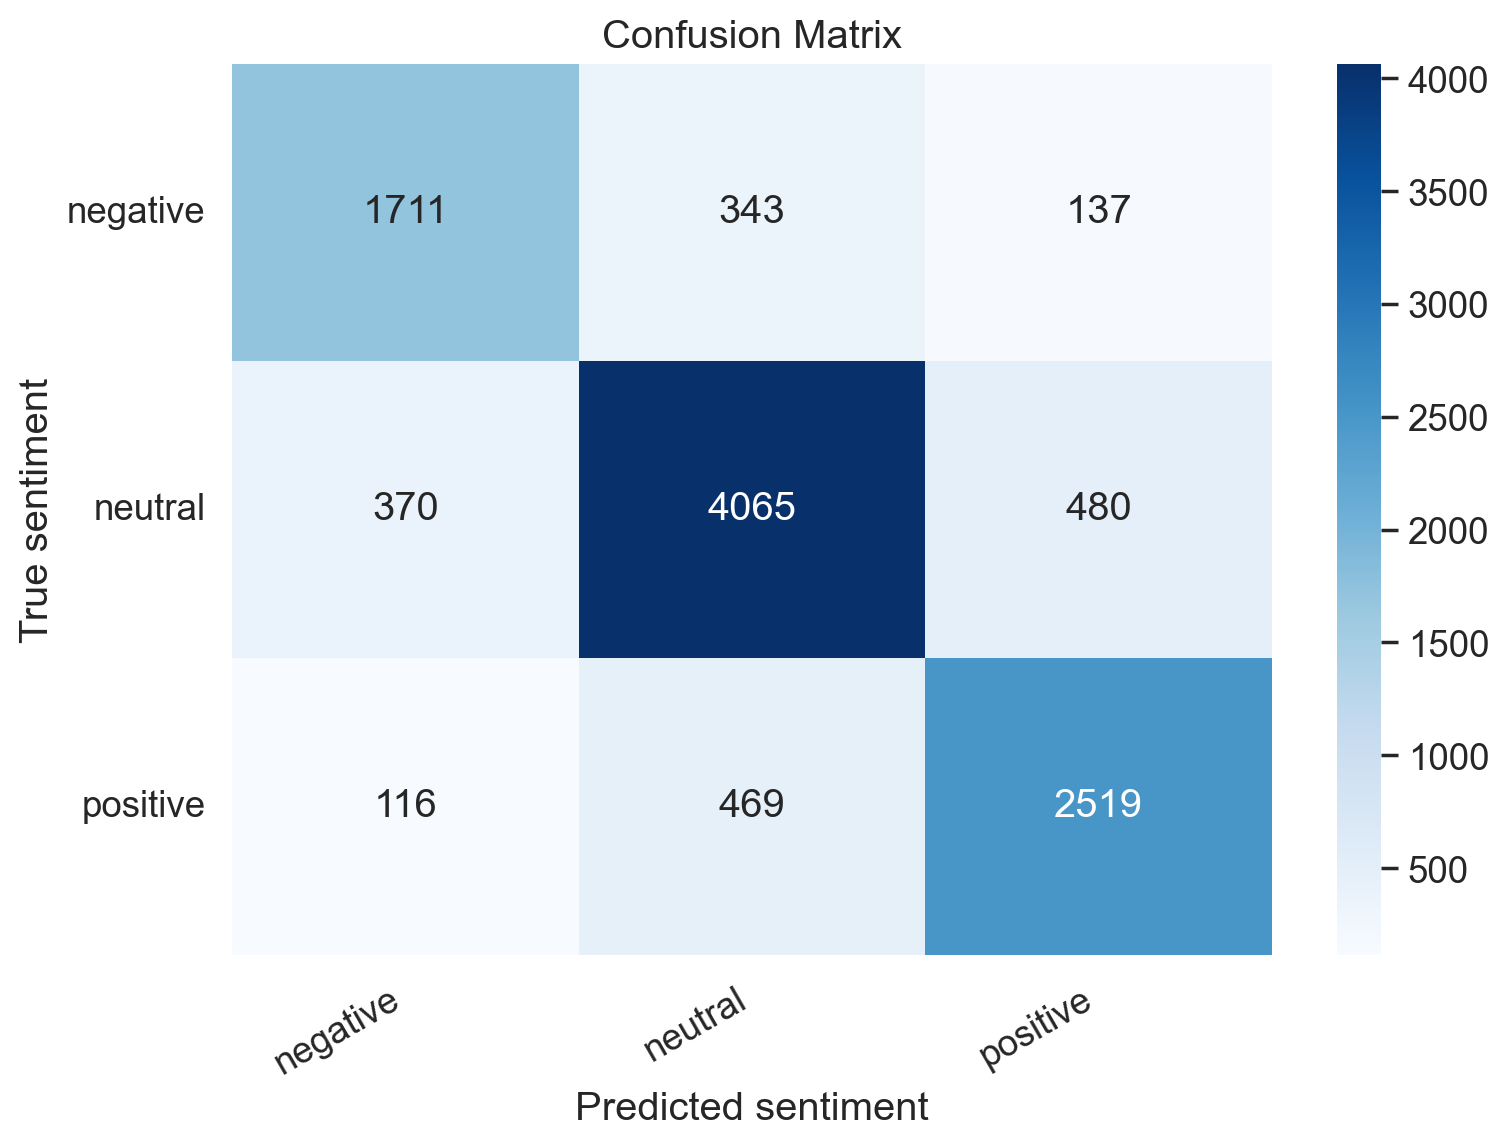

In [38]:
plot_confusion_matrix(y_test, y_pred_db, class_names)

In [39]:
classification_breakdown(y_test, y_pred_db)

Total samples: 10210
Correctly classified: 8295
Partially misclassified (neutral <-> pos/neg): 1662
Misclassified (positive <-> negative): 253


{'correct': 8295, 'partially_misclassified': 1662, 'fully_misclassified': 253}

### deberta-v3-large

In [40]:
model_name = "microsoft/deberta-v3-large"
model_path = "../fine_tuned_models/deberta-v3-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
y_review_texts, y_pred_dl, y_pred_probs_dl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [42]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dl))

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      2191
     neutral       0.83      0.84      0.83      4915
    positive       0.82      0.81      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.81      0.81      0.81     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.8974534769833497


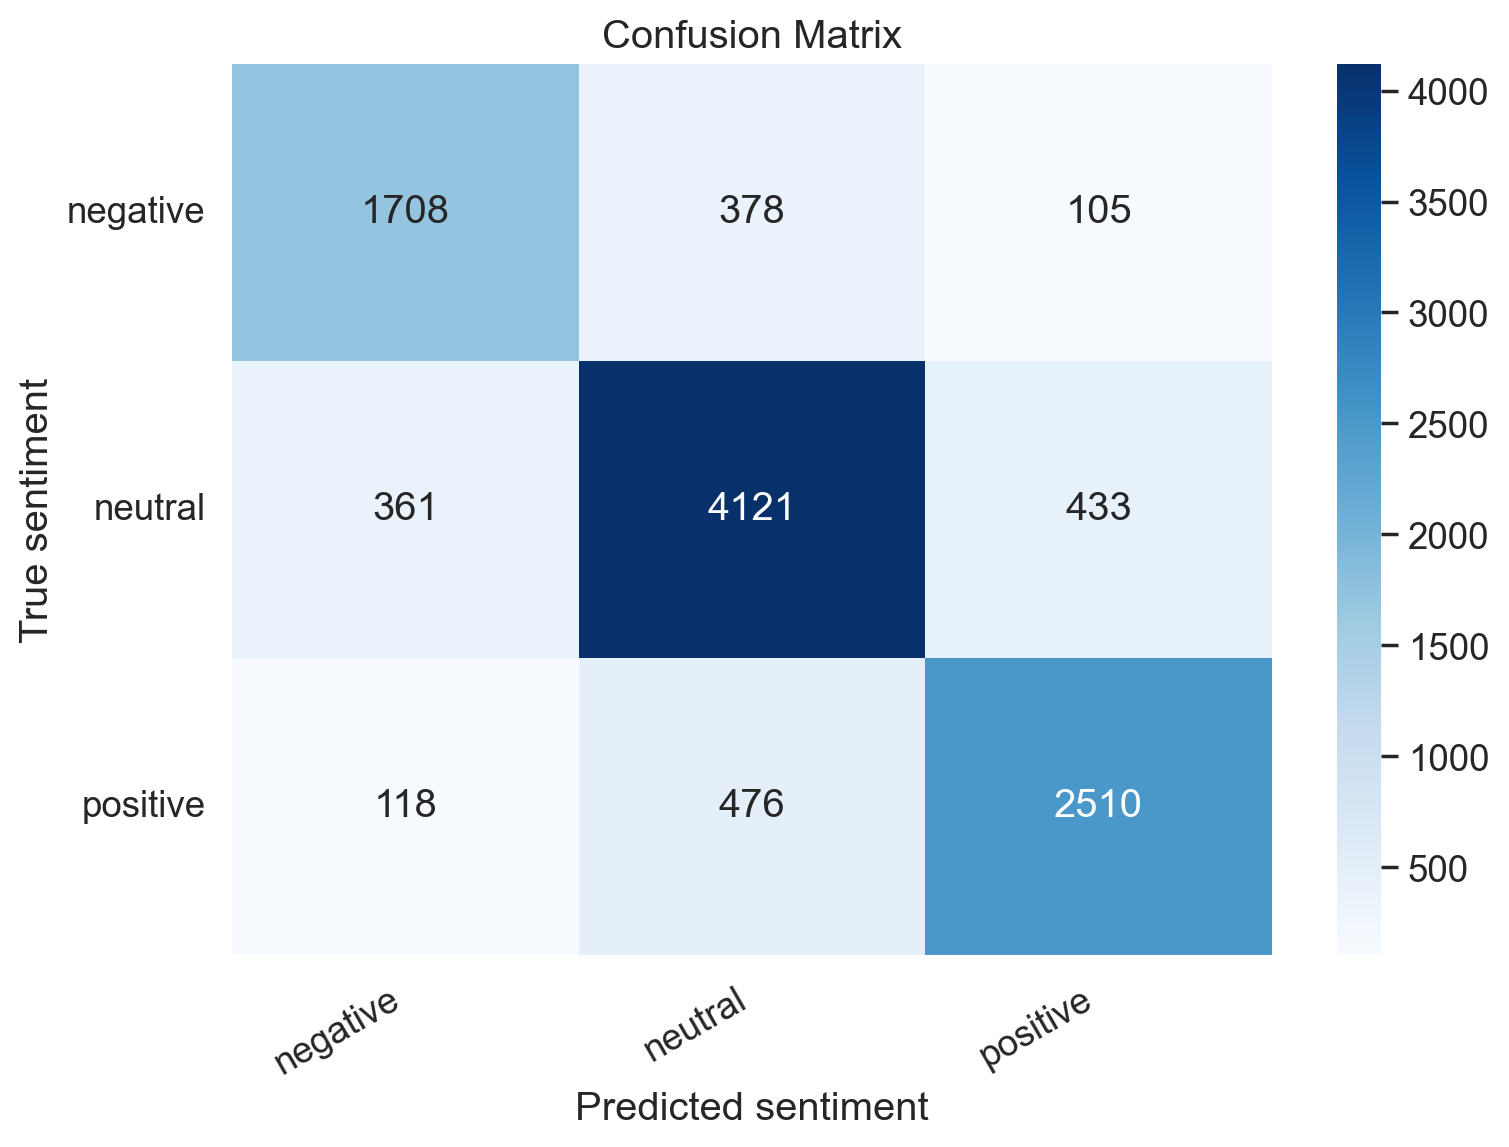

In [43]:
plot_confusion_matrix(y_test, y_pred_dl, class_names)

In [44]:
classification_breakdown(y_test, y_pred_dl)

Total samples: 10210
Correctly classified: 8339
Partially misclassified (neutral <-> pos/neg): 1648
Misclassified (positive <-> negative): 223


{'correct': 8339, 'partially_misclassified': 1648, 'fully_misclassified': 223}

# Aggregating LLMs results

We perform a series of experiments to assess the impact of aggregating predictions from various fine-tuned language models (LLMs). Our goal is to investigate whether model ensembles can enhance performance, and under what conditions such gains are most pronounced. Specifically, we examine the following:

- Whether combining a base model with its multilingual counterpart of the same architecture improves performance.
- Whether ensembling multiple multilingual models enhances predictive accuracy.
- Whether aggregating multiple base models results in performance gains.
- Whether combining base models with their larger counterparts yields improvements.
- Whether augmenting high-performing models with smaller base models leads to meaningful and potentially significant improvements.

## Combining base model and multilingual model
### Distilbert base cased + Distilbert base multilingual cased

In [82]:
dbc_dbmc_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dbc, y_pred_dbmc],
    probs_list=[y_pred_probs_dbc, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [83]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, dbc_dbmc_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, dbc_dbmc_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.69      0.64      0.67      2191
     neutral       0.78      0.82      0.80      4915
    positive       0.75      0.72      0.74      3104

    accuracy                           0.75     10210
   macro avg       0.74      0.73      0.73     10210
weighted avg       0.75      0.75      0.75     10210

L-score is:  0.8524485798237023


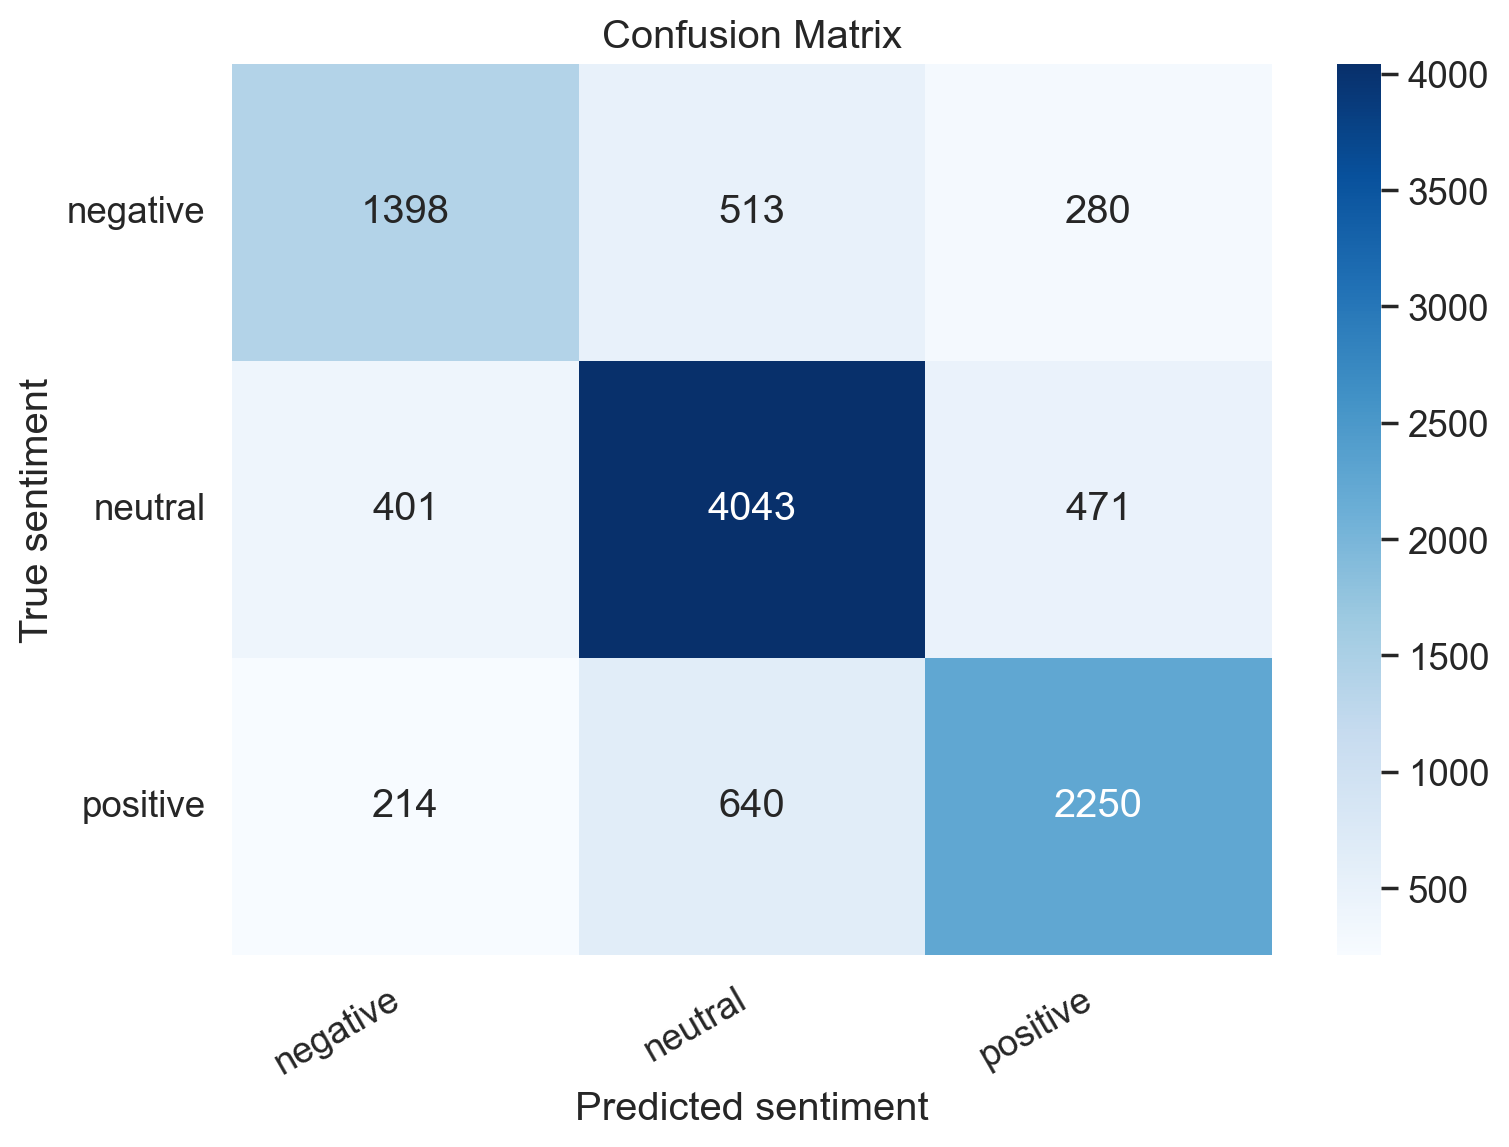

In [84]:
plot_confusion_matrix(y_test, dbc_dbmc_preds_softmax_avg, class_names)

In [85]:
classification_breakdown(y_test, dbc_dbmc_preds_softmax_avg)

Total samples: 10210
Correctly classified: 7691
Partially misclassified (neutral <-> pos/neg): 2025
Misclassified (positive <-> negative): 494


{'correctly_classified': 7691,
 'partially_misclassified': 2025,
 'fully_misclassified': 494}

### Bert base cased + Bert base multilingual cased

In [86]:
bbc_bbmc_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_bbc, y_pred_bbmc],
    probs_list=[y_pred_probs_bbc, y_pred_probs_bbmc],
    strategy="softmax_avg"
)

In [87]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, bbc_bbmc_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, bbc_bbmc_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.71      0.68      0.69      2191
     neutral       0.80      0.82      0.81      4915
    positive       0.76      0.76      0.76      3104

    accuracy                           0.77     10210
   macro avg       0.76      0.75      0.75     10210
weighted avg       0.77      0.77      0.77     10210

L-score is:  0.8626346718903036


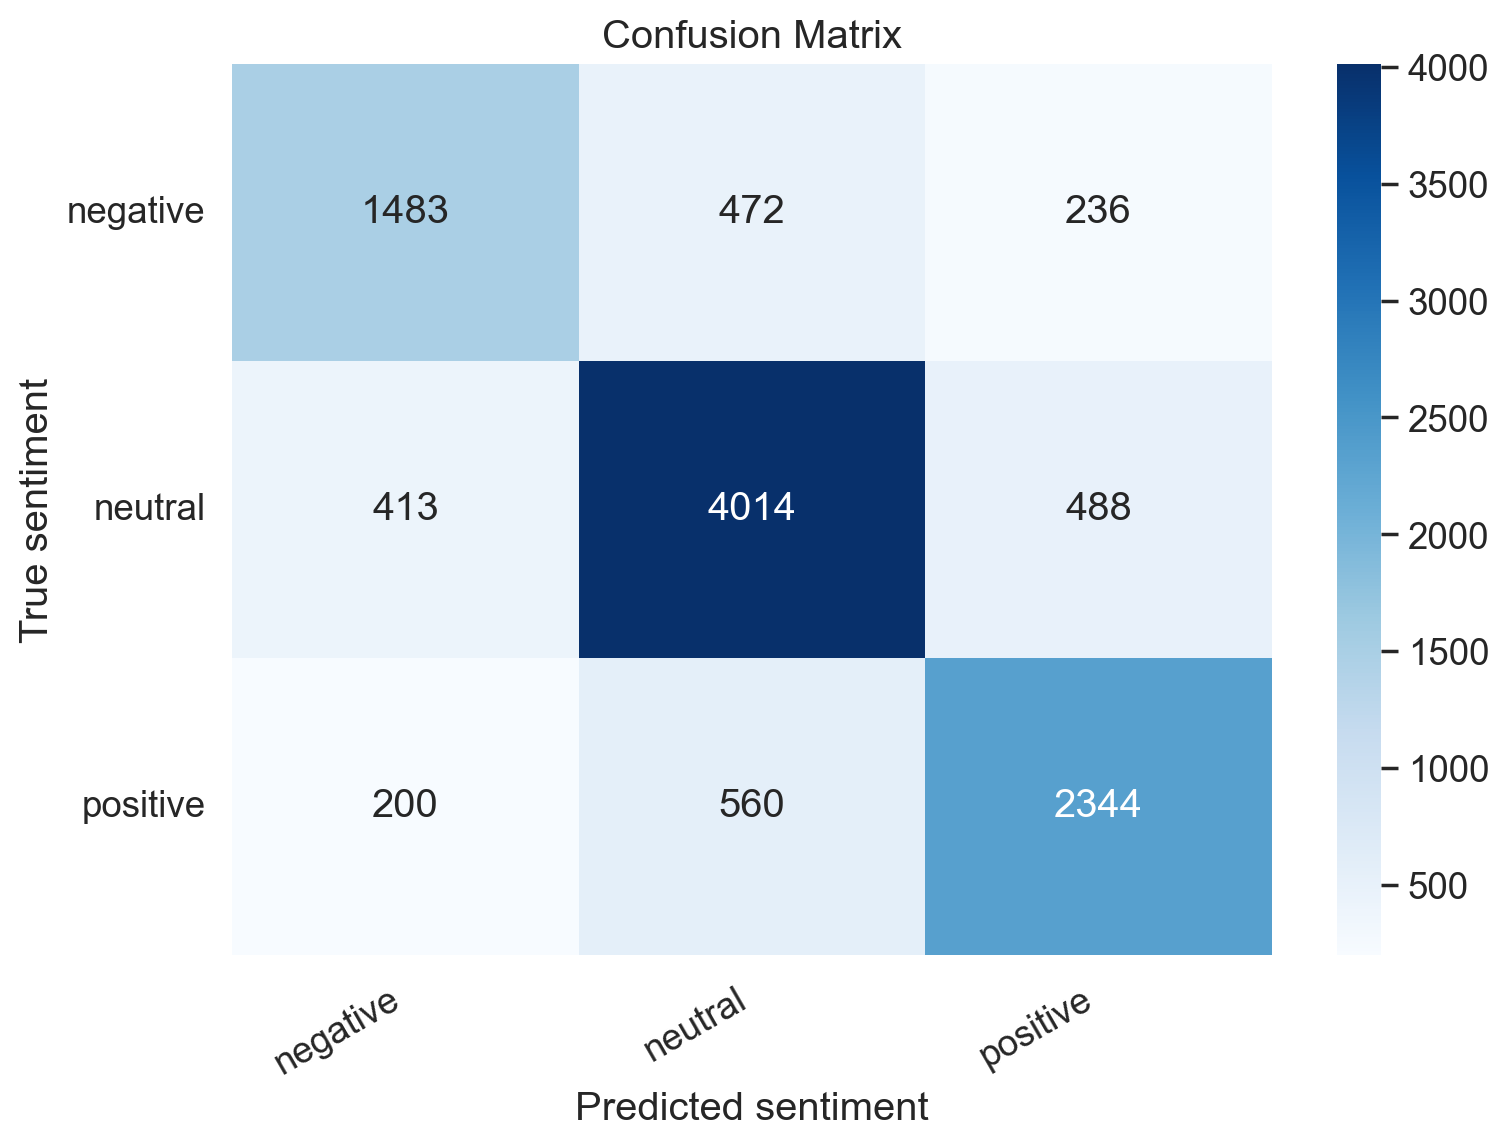

In [88]:
plot_confusion_matrix(y_test, bbc_bbmc_preds_softmax_avg, class_names)

In [89]:
classification_breakdown(y_test, bbc_bbmc_preds_softmax_avg)

Total samples: 10210
Correctly classified: 7841
Partially misclassified (neutral <-> pos/neg): 1933
Misclassified (positive <-> negative): 436


{'correctly_classified': 7841,
 'partially_misclassified': 1933,
 'fully_misclassified': 436}

### Roberta base + Multilingual Roberta base

In [90]:
rb_xlmrb_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_rb, y_pred_xlmrb],
    probs_list=[y_pred_probs_rb, y_pred_probs_xlmrb],
    strategy="softmax_avg"
)

In [91]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, rb_xlmrb_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, rb_xlmrb_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.76      0.74      0.75      2191
     neutral       0.82      0.82      0.82      4915
    positive       0.79      0.80      0.79      3104

    accuracy                           0.80     10210
   macro avg       0.79      0.79      0.79     10210
weighted avg       0.80      0.80      0.80     10210

L-score is:  0.8820763956904996


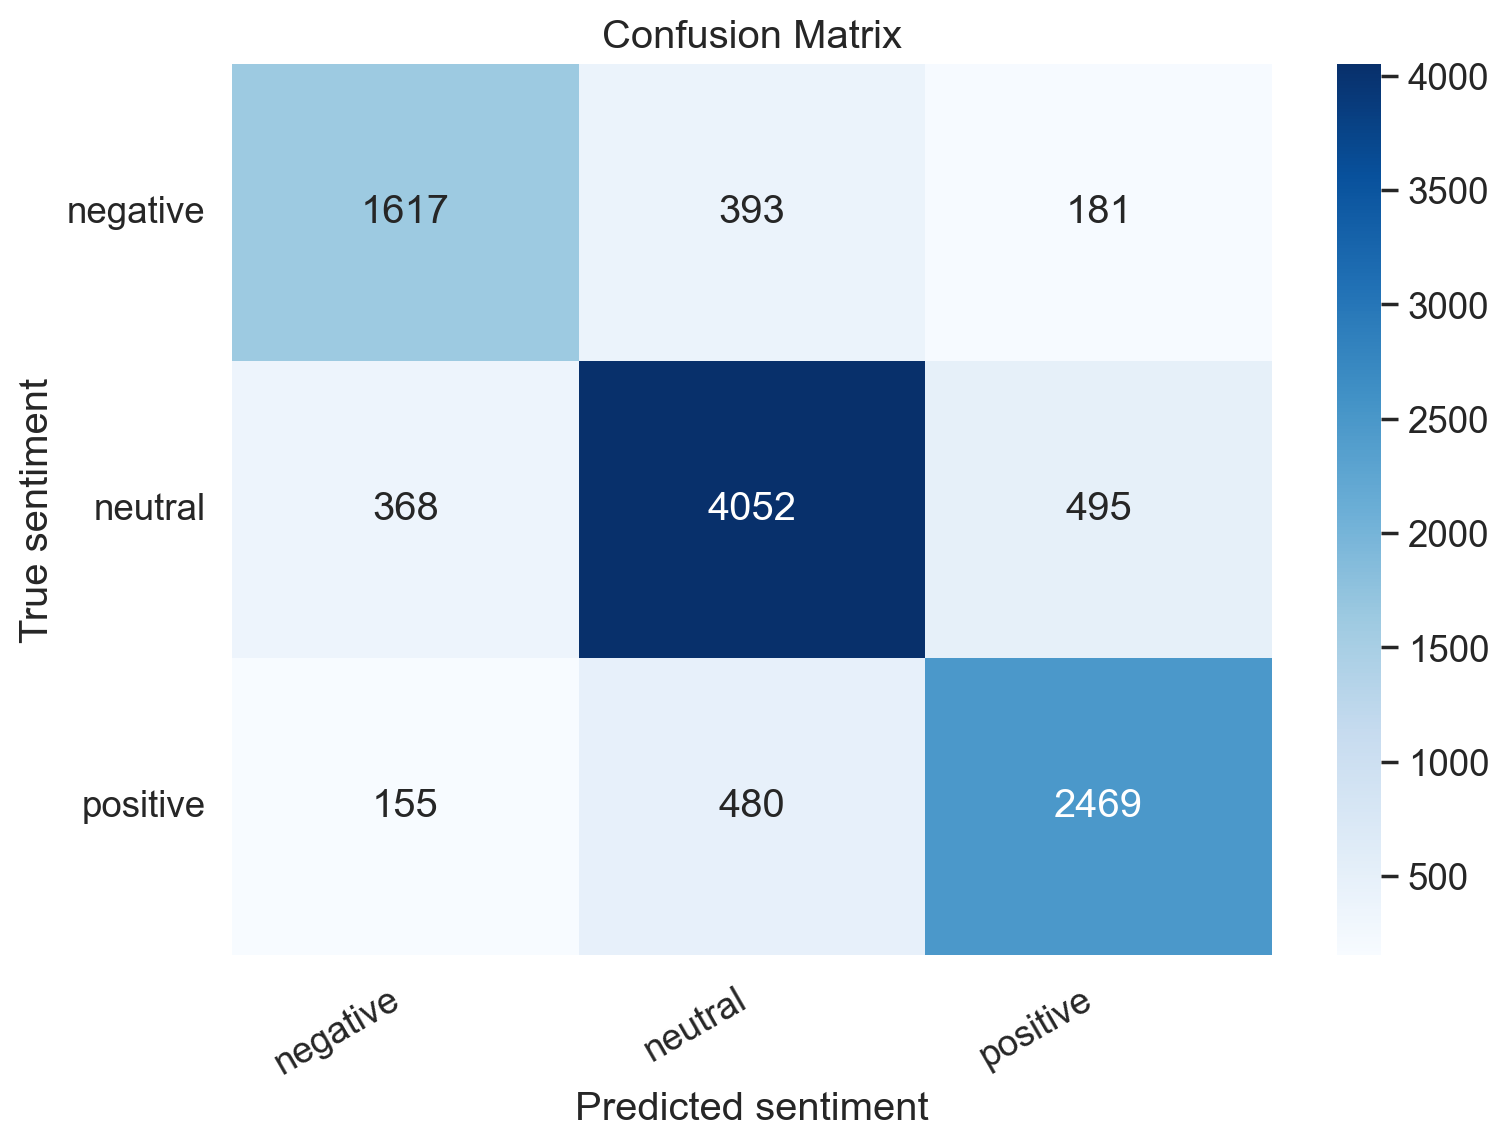

In [92]:
plot_confusion_matrix(y_test, rb_xlmrb_preds_softmax_avg, class_names)

In [93]:
classification_breakdown(y_test, rb_xlmrb_preds_softmax_avg)

Total samples: 10210
Correctly classified: 8138
Partially misclassified (neutral <-> pos/neg): 1736
Misclassified (positive <-> negative): 336


{'correctly_classified': 8138,
 'partially_misclassified': 1736,
 'fully_misclassified': 336}

## Aggregating multilingual models together

Distilbert base multilingual cased + Bert base multilingual cased + Multilingual Roberta base

### Majority voting

In [94]:
dbmc_bbmc_xlmrb_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dbmc, y_pred_bbmc, y_pred_xlmrb],
    probs_list=[y_pred_probs_dbmc, y_pred_probs_bbmc, y_pred_probs_xlmrb],
    strategy="majority"
)

In [95]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, dbmc_bbmc_xlmrb_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, dbmc_bbmc_xlmrb_preds_majority))

              precision    recall  f1-score   support

    negative       0.69      0.64      0.67      2191
     neutral       0.78      0.83      0.80      4915
    positive       0.77      0.73      0.75      3104

    accuracy                           0.76     10210
   macro avg       0.75      0.73      0.74     10210
weighted avg       0.76      0.76      0.76     10210

L-score is:  0.8560235063663075


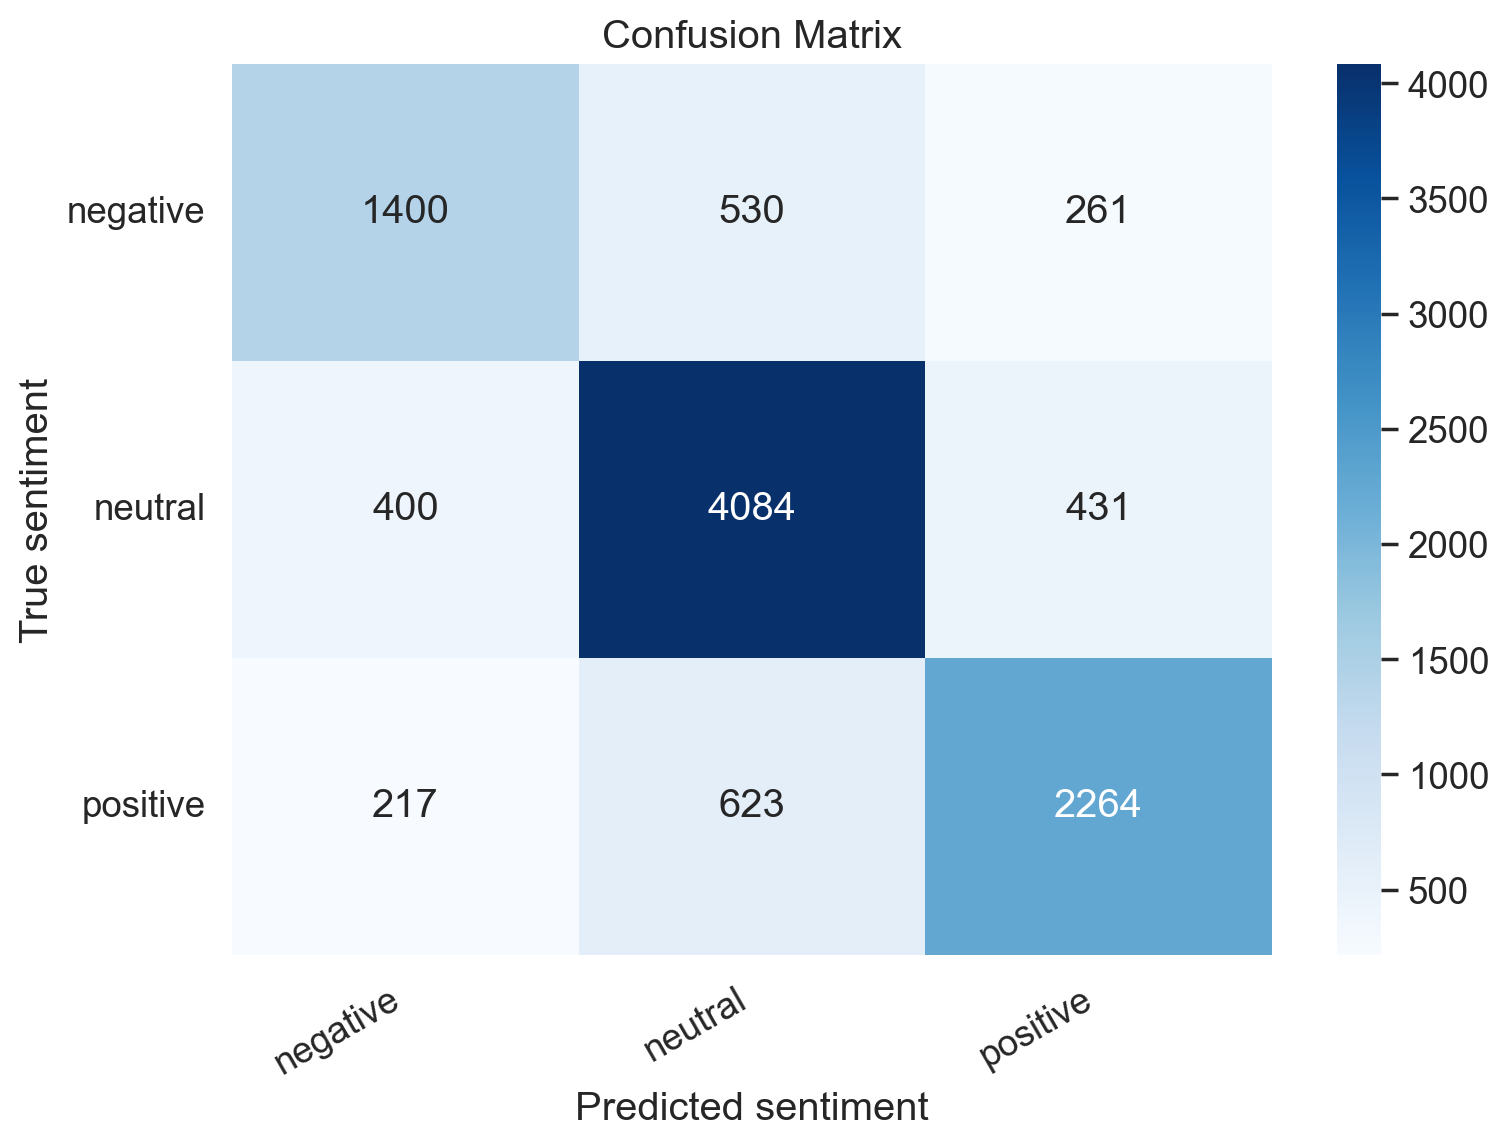

In [96]:
plot_confusion_matrix(y_test, dbmc_bbmc_xlmrb_preds_majority, class_names)

In [97]:
classification_breakdown(y_test, dbmc_bbmc_xlmrb_preds_majority)

Total samples: 10210
Correctly classified: 7748
Partially misclassified (neutral <-> pos/neg): 1984
Misclassified (positive <-> negative): 478


{'correctly_classified': 7748,
 'partially_misclassified': 1984,
 'fully_misclassified': 478}

### Softmax average

In [98]:
dbmc_bbmc_xlmrb_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dbmc, y_pred_bbmc, y_pred_xlmrb],
    probs_list=[y_pred_probs_dbmc, y_pred_probs_bbmc, y_pred_probs_xlmrb],
    strategy="softmax_avg"
)

In [99]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, dbmc_bbmc_xlmrb_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, dbmc_bbmc_xlmrb_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.71      0.65      0.68      2191
     neutral       0.79      0.83      0.81      4915
    positive       0.77      0.74      0.75      3104

    accuracy                           0.76     10210
   macro avg       0.75      0.74      0.75     10210
weighted avg       0.76      0.76      0.76     10210

L-score is:  0.8600881488736533


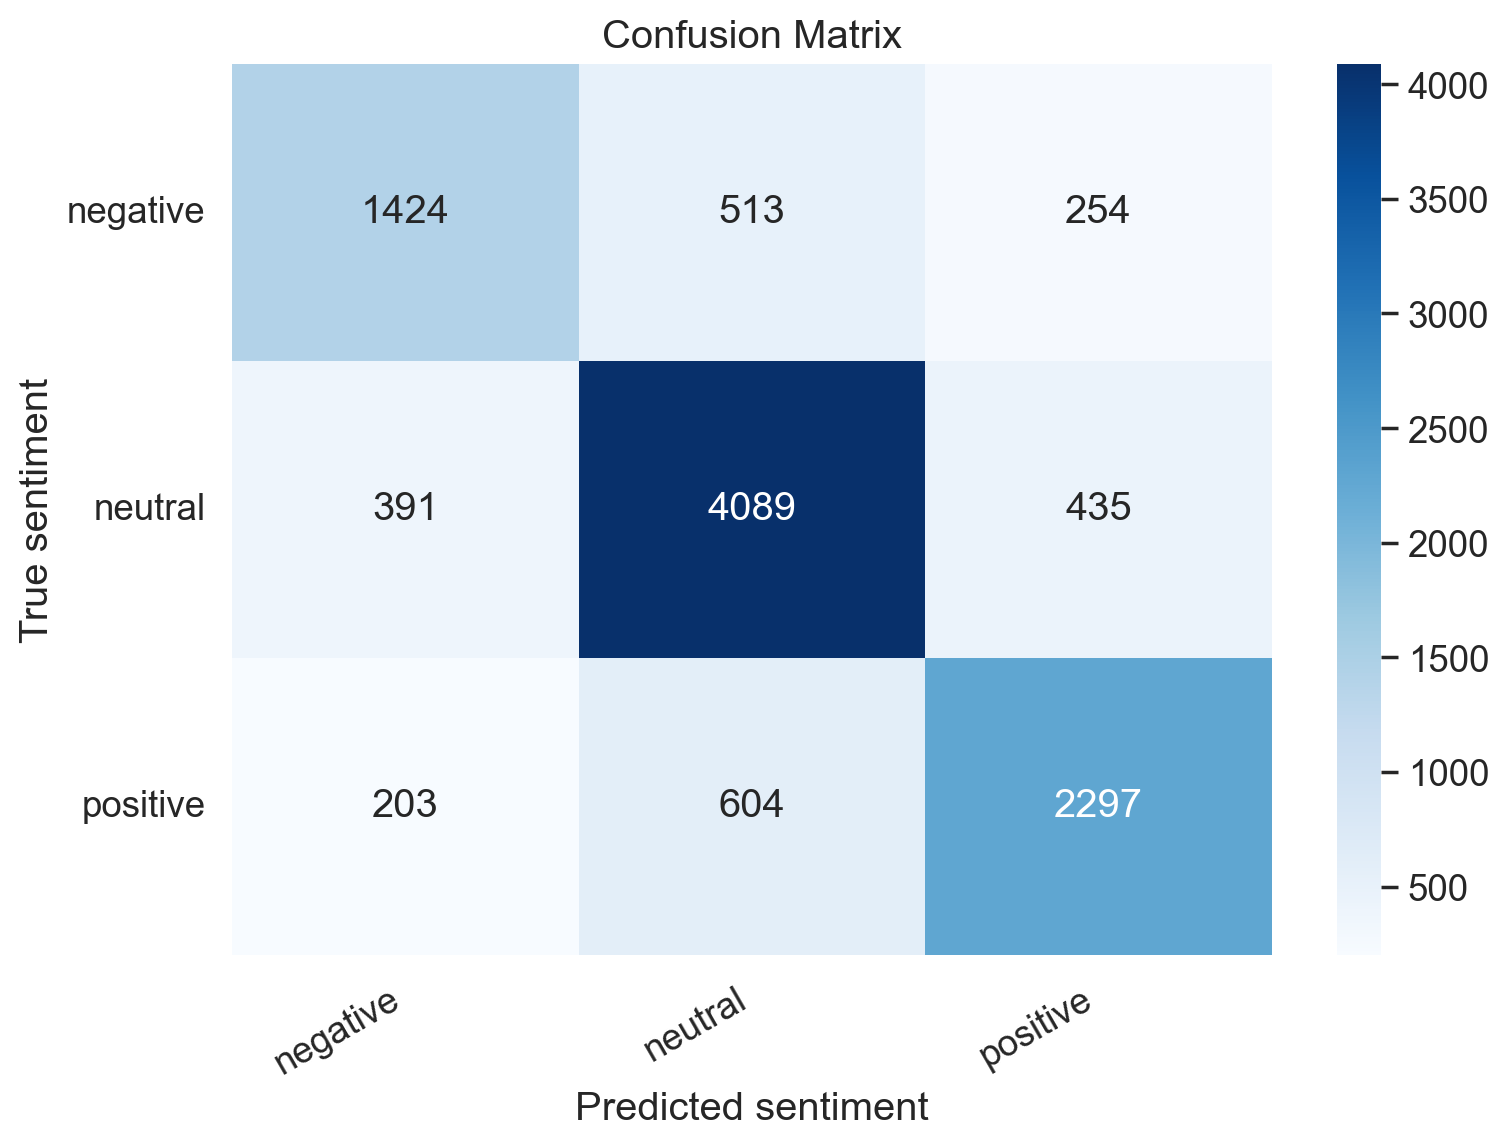

In [100]:
plot_confusion_matrix(y_test, dbmc_bbmc_xlmrb_preds_softmax_avg, class_names)

In [101]:
classification_breakdown(y_test, dbmc_bbmc_xlmrb_preds_softmax_avg)

Total samples: 10210
Correctly classified: 7810
Partially misclassified (neutral <-> pos/neg): 1943
Misclassified (positive <-> negative): 457


{'correctly_classified': 7810,
 'partially_misclassified': 1943,
 'fully_misclassified': 457}

## Aggregating base models



### Majority voting

In [102]:
dbc_bbc_rb_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dbmc, y_pred_bbmc, y_pred_xlmrb],
    probs_list=[y_pred_probs_dbmc, y_pred_probs_bbmc, y_pred_probs_xlmrb],
    strategy="majority"
)

In [103]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, dbc_bbc_rb_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, dbc_bbc_rb_preds_majority))

              precision    recall  f1-score   support

    negative       0.69      0.64      0.67      2191
     neutral       0.78      0.83      0.80      4915
    positive       0.77      0.73      0.75      3104

    accuracy                           0.76     10210
   macro avg       0.75      0.73      0.74     10210
weighted avg       0.76      0.76      0.76     10210

L-score is:  0.8560235063663075


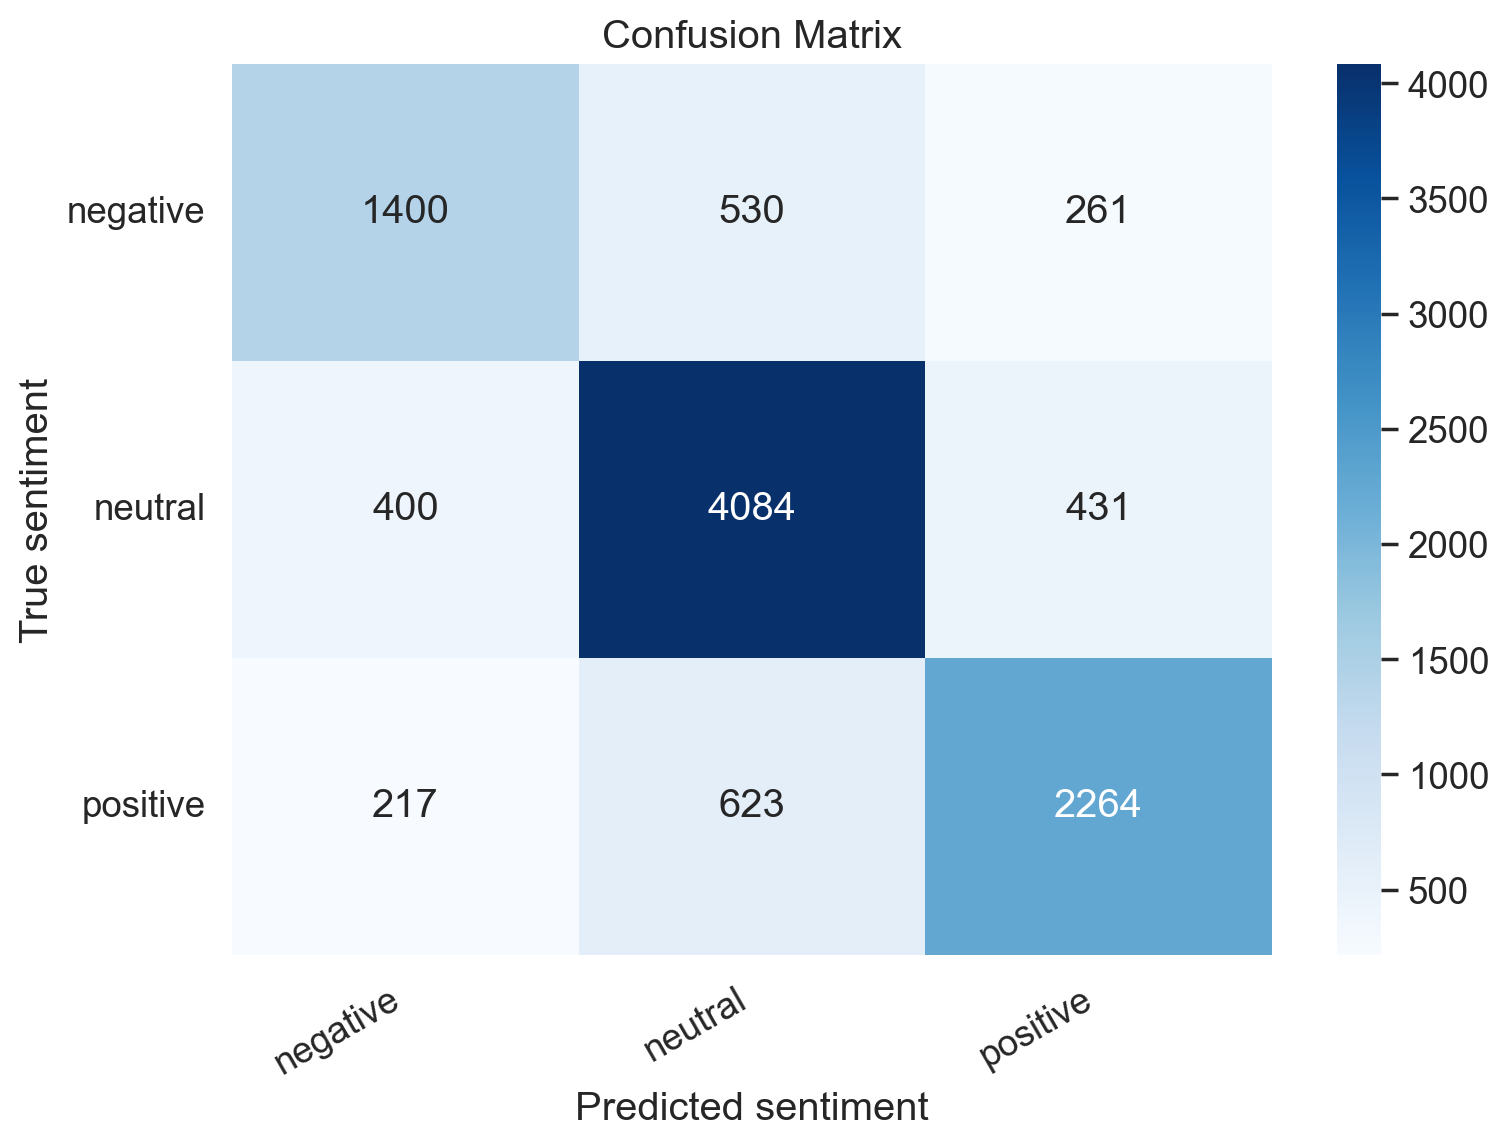

In [104]:
plot_confusion_matrix(y_test, dbc_bbc_rb_preds_majority, class_names)

In [105]:
classification_breakdown(y_test, dbc_bbc_rb_preds_majority)

Total samples: 10210
Correctly classified: 7748
Partially misclassified (neutral <-> pos/neg): 1984
Misclassified (positive <-> negative): 478


{'correctly_classified': 7748,
 'partially_misclassified': 1984,
 'fully_misclassified': 478}

### Softmax averaging

In [106]:
dbc_bbc_rb_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dbc, y_pred_bbc, y_pred_rb],
    probs_list=[y_pred_probs_dbc, y_pred_probs_bbc, y_pred_probs_rb],
    strategy="softmax_avg"
)

In [107]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, dbc_bbc_rb_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, dbc_bbc_rb_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.73      0.71      0.72      2191
     neutral       0.80      0.82      0.81      4915
    positive       0.78      0.77      0.77      3104

    accuracy                           0.78     10210
   macro avg       0.77      0.77      0.77     10210
weighted avg       0.78      0.78      0.78     10210

L-score is:  0.8723310479921645


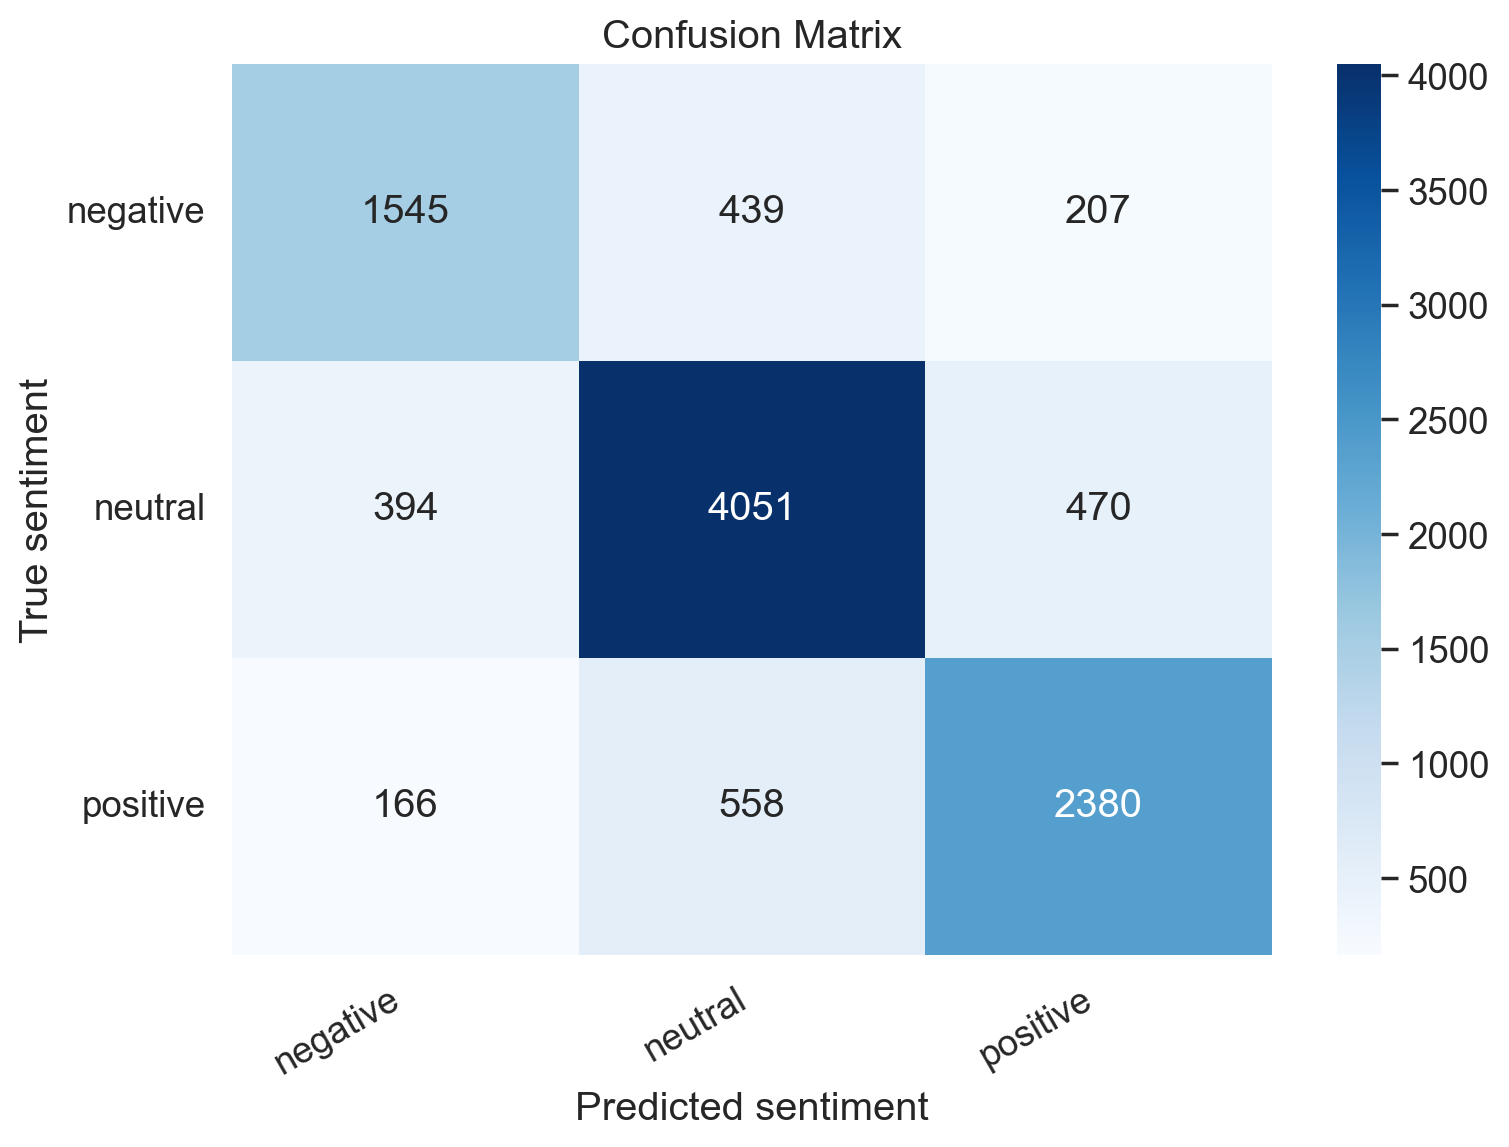

In [108]:
plot_confusion_matrix(y_test, dbc_bbc_rb_preds_softmax_avg, class_names)

In [109]:
classification_breakdown(y_test, dbc_bbc_rb_preds_softmax_avg)

Total samples: 10210
Correctly classified: 7976
Partially misclassified (neutral <-> pos/neg): 1861
Misclassified (positive <-> negative): 373


{'correctly_classified': 7976,
 'partially_misclassified': 1861,
 'fully_misclassified': 373}

## Aggregating base model with their larger model

### Roberta base + Roberta large

In [110]:
rb_rl_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_rb, y_pred_rl],
    probs_list=[y_pred_probs_rb, y_pred_probs_rl],
    strategy="softmax_avg"
)

In [111]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, rb_rl_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, rb_rl_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76      2191
     neutral       0.83      0.84      0.83      4915
    positive       0.80      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.80      0.80     10210
weighted avg       0.81      0.81      0.81     10210

L-score is:  0.8898139079333987


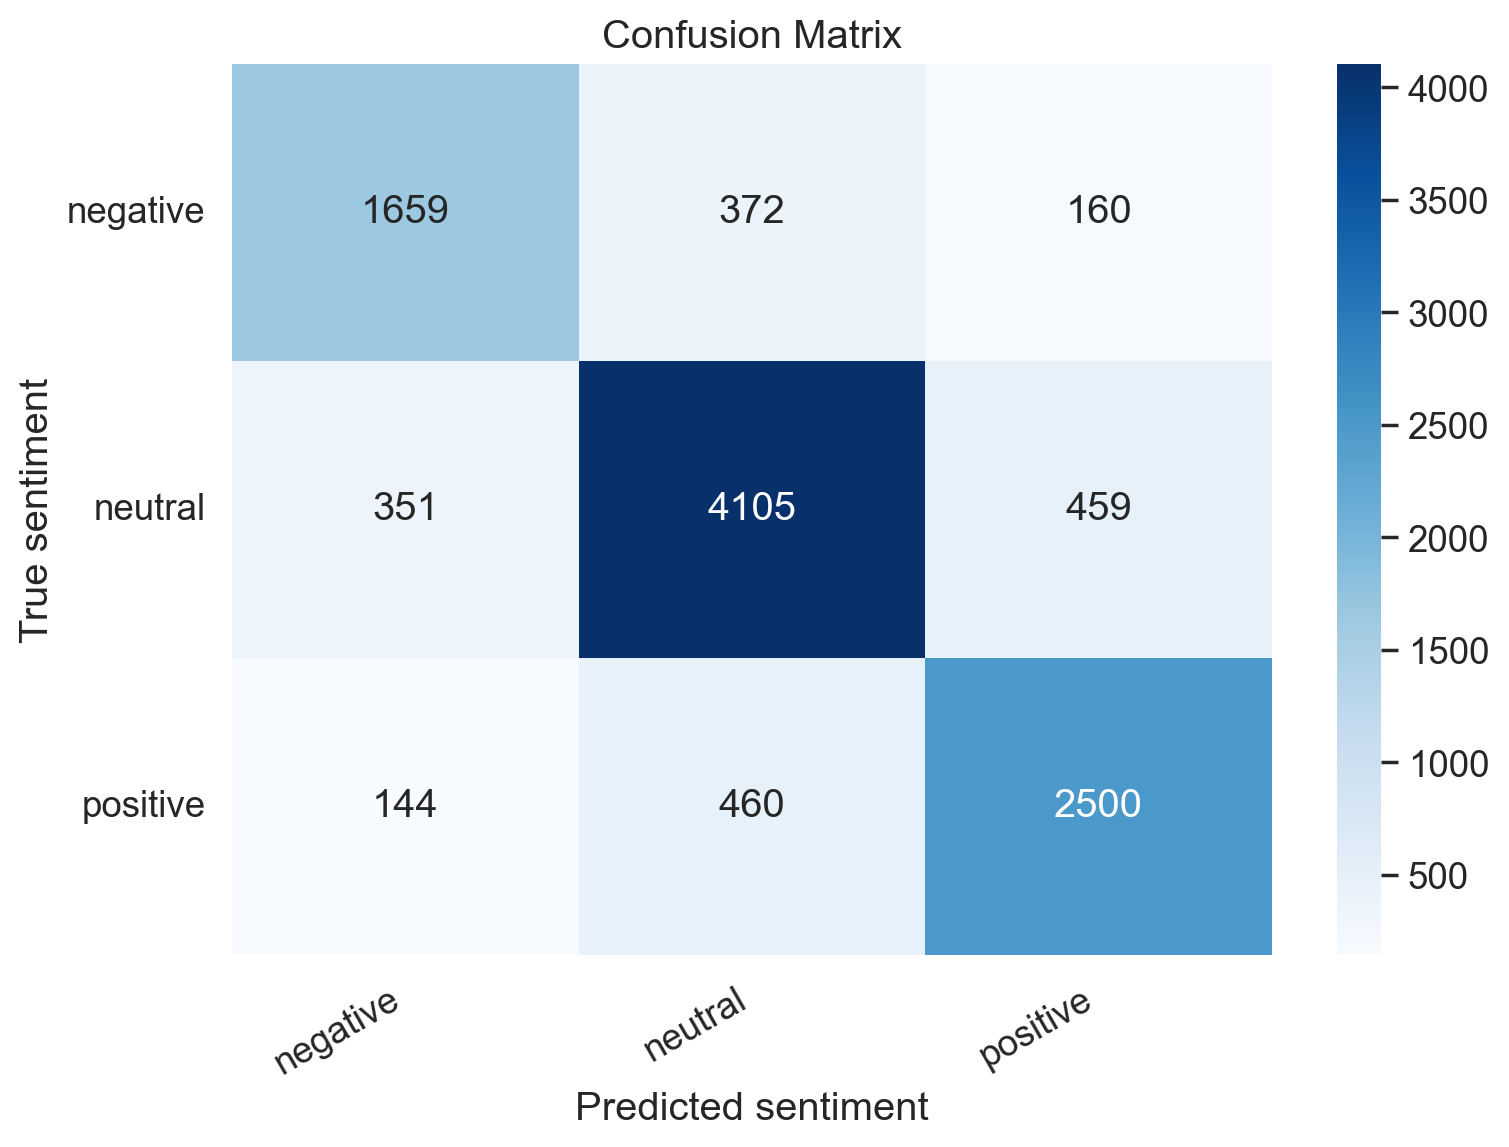

In [112]:
plot_confusion_matrix(y_test, rb_rl_preds_softmax_avg, class_names)

In [113]:
classification_breakdown(y_test, rb_rl_preds_softmax_avg)

Total samples: 10210
Correctly classified: 8264
Partially misclassified (neutral <-> pos/neg): 1642
Misclassified (positive <-> negative): 304


{'correctly_classified': 8264,
 'partially_misclassified': 1642,
 'fully_misclassified': 304}

### Deberta-v3 base + Deberta-v3 large

In [114]:
db_dl_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_db, y_pred_dl],
    probs_list=[y_pred_probs_db, y_pred_probs_dl],
    strategy="softmax_avg"
)

In [115]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, db_dl_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, db_dl_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.84      4915
    positive       0.82      0.82      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.81      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.9003917727717924


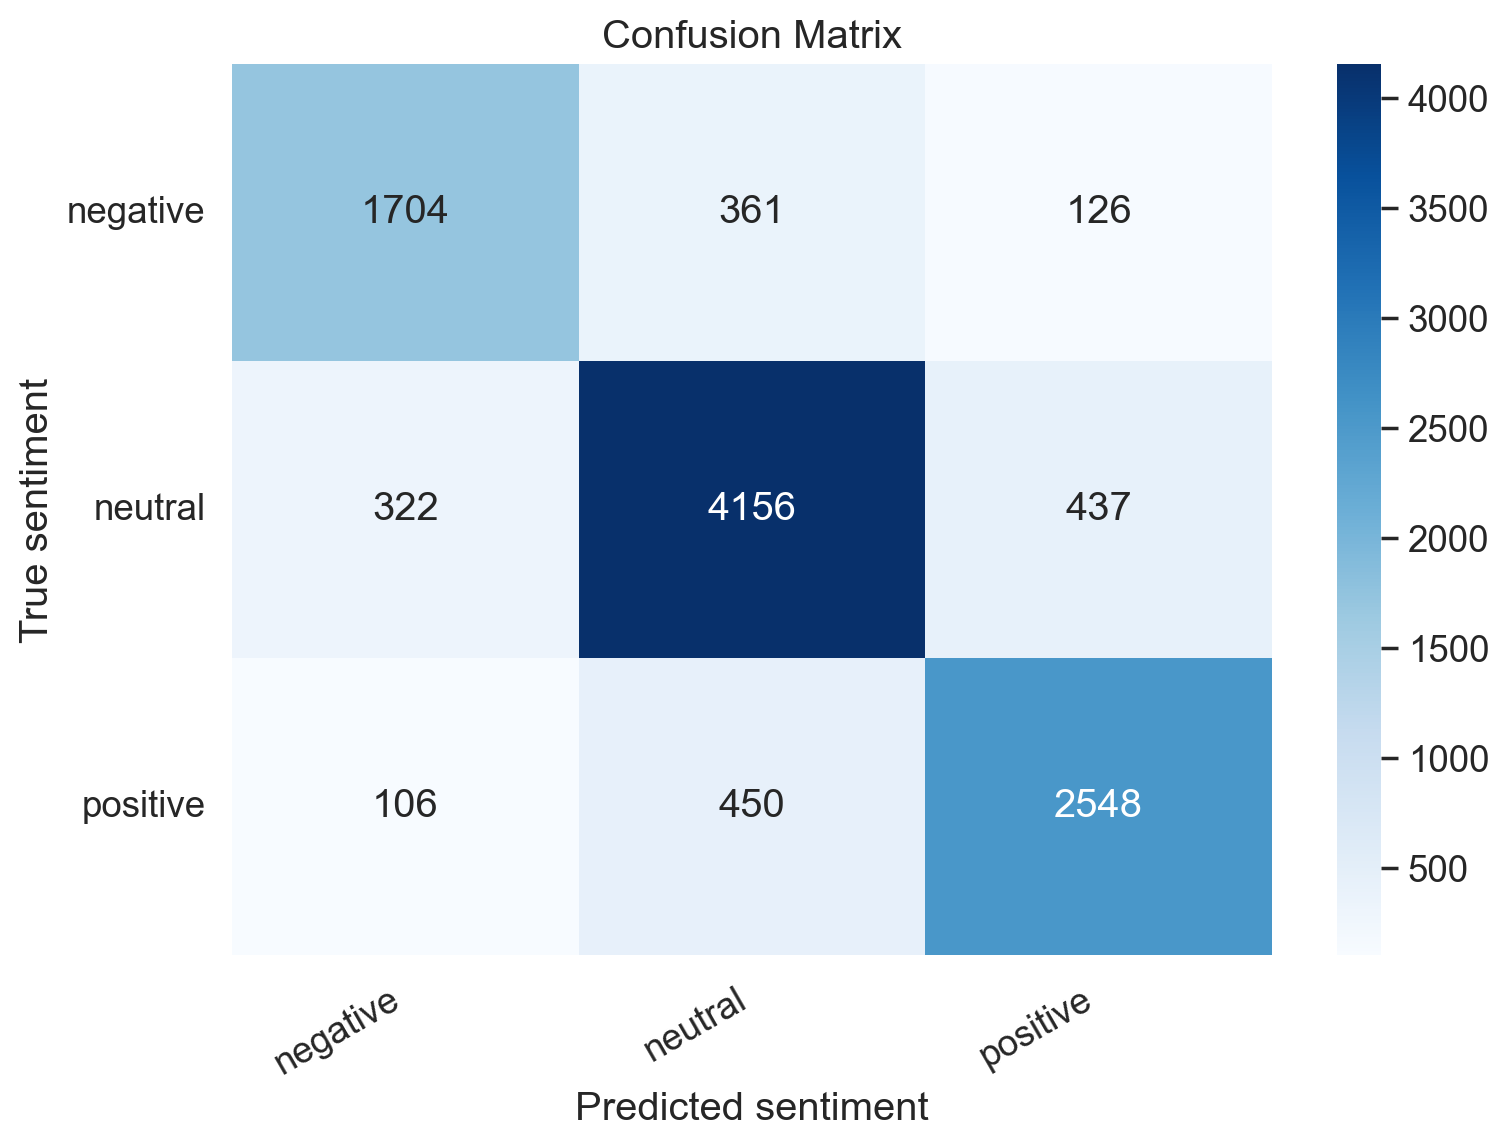

In [116]:
plot_confusion_matrix(y_test, db_dl_preds_softmax_avg, class_names)

In [117]:
classification_breakdown(y_test, db_dl_preds_softmax_avg)

Total samples: 10210
Correctly classified: 8408
Partially misclassified (neutral <-> pos/neg): 1570
Misclassified (positive <-> negative): 232


{'correctly_classified': 8408,
 'partially_misclassified': 1570,
 'fully_misclassified': 232}

## Aggregating deberta with smaller models

### Majority voting

In [132]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db],
    strategy="majority"
)

In [133]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_majority))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.84      4915
    positive       0.82      0.82      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.9011753183153771


In [134]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_dbmc, y_pred_db],
    probs_list=[y_pred_probs_dl, y_pred_probs_dbmc, y_pred_probs_db],
    strategy="majority"
)

In [135]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_majority))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.79      2191
     neutral       0.83      0.86      0.84      4915
    positive       0.84      0.81      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.81      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.9013222331047992


In [136]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_dbmc],
    strategy="majority"
)

In [137]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_majority))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.83      0.85      0.84      4915
    positive       0.83      0.81      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.81      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.901077375122429


### Softmax average

In [124]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db],
    strategy="softmax_avg"
)

In [125]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.84      4915
    positive       0.82      0.82      0.82      3104

    accuracy                           0.83     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.83      0.83      0.83     10210

L-score is:  0.9019588638589618


In [128]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_dbmc, y_pred_db],
    probs_list=[y_pred_probs_dl, y_pred_probs_dbmc, y_pred_probs_db],
    strategy="softmax_avg"
)

In [129]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.81      0.78      0.79      2191
     neutral       0.83      0.86      0.84      4915
    positive       0.83      0.81      0.82      3104

    accuracy                           0.83     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.83      0.83      0.83     10210

L-score is:  0.9026444662095985


In [122]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [123]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.85      4915
    positive       0.83      0.82      0.83      3104

    accuracy                           0.83     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.83      0.83      0.83     10210

L-score is:  0.9033790401567091


## Submission

In [130]:
submission_df = load_submission_data()

def create_submission_data_loader_with_model(model_name, config, submission_df):
    llm_tokenizer = AutoTokenizer.from_pretrained(model_name)
    submission_data_loader = create_data_loader(submission_df, llm_tokenizer, config.max_len, config.batch_size)

    return submission_data_loader, llm_tokenizer

distilbert/distilbert-base-multilingual-cased

In [57]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("distilbert/distilbert-base-multilingual-cased", config, submission_df)

In [131]:
y_review_texts, y_pred_dbmc, y_pred_probs_dbmc, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

deberta-v3-base

In [117]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("microsoft/deberta-v3-base", config, submission_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [118]:
y_review_texts, y_pred_db, y_pred_probs_db, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

deberta-v3-large

In [119]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("microsoft/deberta-v3-large", config, submission_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [120]:
y_review_texts, y_pred_dl, y_pred_probs_dl, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

roberta-large

In [121]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("FacebookAI/roberta-large", config, submission_df)

In [122]:
y_review_texts, y_pred_rl, y_pred_probs_rl, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

### Majority voting submission

In [123]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    strategy="majority"
)

In [124]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(final_preds_majority, label_map=label_map, output_path="../submissions/majority_voting_submission.csv")

Submission file saved to ../submissions/majority_voting_submission.csv


In [125]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [129]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(final_preds_softmax_avg, label_map=label_map, output_path="../submissions/softmax_avg.csv")

Submission file saved to ../submissions/softmax_avg.csv
